In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle 
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA

In [2]:
pickle_in = open("indeed_db_v2.pickle", 'rb')
s_v2 = pickle.load(pickle_in)

In [3]:
s_v2.columns

Index(['entreprise', 'keyword_metier', 'description', 'ID', 'Contract',
       'Location', 'Salary_type', 'Salary_clean', 'Salary', 'Job_class',
       'Job_title', 'Description', 'Description_filtered', 'Data_qualities',
       'Num_data_qualities', 'Data_skills', 'Num_data_skills', 'Dev_qualities',
       'Num_dev_qualities', 'Dev_skills', 'Num_dev_skills',
       'No_technical_skills', 'Num_no_technical_skills', 'Experience'],
      dtype='object')

In [4]:
oas = s_v2[s_v2['Salary_type'] == 'y']  ####Select job announce with annual salaries

#How many rows of type data
#oas['Job_class'].value_counts()

oas['Salary'] = oas['Salary'].astype('int') ##Convert Salary into integer 

oas = oas[oas['Contract'] != 'contrat pro'] ##Delete contrat pro 
oas.reset_index(drop=True, inplace=True)    ##reset index after dropping rows 

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [5]:
oas.head()

,entreprise,keyword_metier,description,ID,Contract,Location,Salary_type,Salary_clean,Salary,Job_class,...,Num_data_qualities,Data_skills,Num_data_skills,Dev_qualities,Num_dev_qualities,Dev_skills,Num_dev_skills,No_technical_skills,Num_no_technical_skills,Experience
0,badenoch & clark,cyber securité,"localité bordeaux\nbadenoch + clark, cabinet d...",bb1ce865eacc6833,cdi,33,y,65000-75000,70000,0,...,1,[],0,[],0,[],0,"[communication, gestion, anglais]",3,3
1,manpower,cyber securité,l'entreprise\nmanpower cabinet recrutement bor...,81e0457a745c8d29,cdi,33,y,35000-40000,37500,0,...,1,[],0,[],0,[],0,"[communication, gestion]",2,1
2,randstad search,data consultant,randstad search recrute pour un cabinet de con...,e04ee30b5b586da7,cdi,33,y,40000,40000,1,...,0,[tableau],1,[],0,[],0,[gestion],1,1
3,synchrone,data consultant,"votre rôle, vos responsabilités\nnous menons u...",04f8e416e7139d1f,cdi,75,y,25000-50000,37500,1,...,1,[],0,"[cloud, fullstack, mobile]",3,"[css, html, api, java]",4,[agile],1,1
4,synchrone,data consultant,"votre rôle, vos responsabilités\nnous menons u...",ce29173ff827a5a6,cdi,75,y,30000-55000,42500,1,...,0,[python],1,"[cloud, mobile]",2,[],0,[],0,2


In [6]:
oas.columns

Index(['entreprise', 'keyword_metier', 'description', 'ID', 'Contract',
       'Location', 'Salary_type', 'Salary_clean', 'Salary', 'Job_class',
       'Job_title', 'Description', 'Description_filtered', 'Data_qualities',
       'Num_data_qualities', 'Data_skills', 'Num_data_skills', 'Dev_qualities',
       'Num_dev_qualities', 'Dev_skills', 'Num_dev_skills',
       'No_technical_skills', 'Num_no_technical_skills', 'Experience'],
      dtype='object')

In [7]:
oas['Contract'].value_counts()

cdi                        1642
cdd                          13
intérim                      10
freelance / indépendant       4
Name: Contract, dtype: int64

In [8]:
dummy = oas[['Salary_clean', 'Salary', 'Job_class', 'Experience', 'Contract', 'Location', \
     'Job_title', 'Description', 'Description_filtered']]

In [9]:
dummy.shape

(1669, 9)

# Create columns of y: max, min, mean; cut3, cut4, qcut3, qcut4 

In [10]:
dummy['Salary_max'] = '0'  #Create Salary Maximum column
dummy['Salary_min'] = '0'  #Create Salary Minimum column 

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [11]:
dummy['Salary_clean'].head()

0    65000-75000
1    35000-40000
2          40000
3    25000-50000
4    30000-55000
Name: Salary_clean, dtype: object

In [12]:
dummy['Salary_clean'] = dummy['Salary_clean'].str.split('-')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [13]:
dummy['Salary_clean'].head()

0    [65000, 75000]
1    [35000, 40000]
2           [40000]
3    [25000, 50000]
4    [30000, 55000]
Name: Salary_clean, dtype: object

In [14]:
dummy['Salary_clean'] = dummy['Salary_clean'].apply(lambda x: x*2 if len(x) == 1 else x)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [15]:
dummy['Salary_clean'].head()

0    [65000, 75000]
1    [35000, 40000]
2    [40000, 40000]
3    [25000, 50000]
4    [30000, 55000]
Name: Salary_clean, dtype: object

In [16]:
dummy['Salary_min'] = dummy['Salary_clean'].str[0]
dummy['Salary_max'] = dummy['Salary_clean'].str[1]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [17]:
dummy['Salary_min'] = dummy['Salary_min'].astype(int)
dummy['Salary_max'] = dummy['Salary_max'].astype(int)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [18]:
dummy[dummy['Contract'] == 'freelance / indépendant']

,Salary_clean,Salary,Job_class,Experience,Contract,Location,Job_title,Description,Description_filtered,Salary_max,Salary_min
387,"[45000, 45000]",45000,1,2,freelance / indépendant,75,data engineer habilitable salarié ou freelance,"[intitulé, data, engineer, confirmé, expérienc...","[intitulé, data, engineer, confirmé, expérienc...",45000,45000
394,"[35000, 55000]",45000,1,1,freelance / indépendant,75,data engineer freelance,"[gentis, is, a, belgian, recruitment, company,...","[gentis, belgian, recruitment, company, headqu...",55000,35000
446,"[45000, 45000]",45000,0,2,freelance / indépendant,75,développeur cc++ habilitable salarié ou freel...,"[intitulé, développeur, c, c, d, applications,...","[intitulé, développeur, applications, embarqué...",45000,45000
1075,"[50000, 60000]",55000,0,3,freelance / indépendant,75,architecte sécurité cloud freelance,"[la, mission, a, pour, objectif, de, conseille...","[mission, objectif, conseiller, accompagner, s...",60000,50000


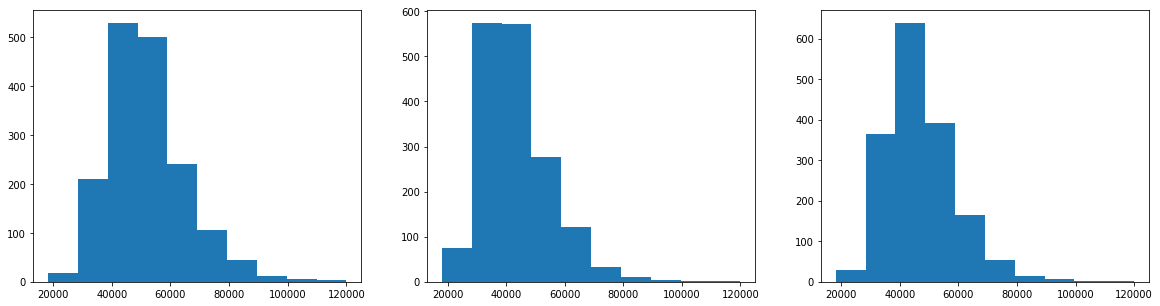

In [19]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
plt.hist(dummy['Salary_max'])

plt.subplot(1, 3, 2)
plt.hist(dummy['Salary_min']) 


plt.subplot(1, 3, 3)
plt.hist(dummy['Salary'])

plt.show()

# Detect outliers 
result : keep outliers 

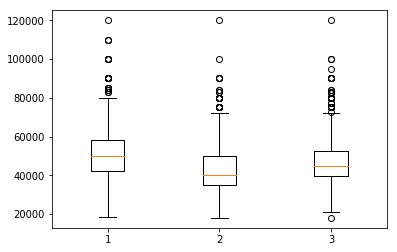

In [20]:
plt.boxplot([dummy['Salary_max'], dummy['Salary_min'], dummy['Salary']])
plt.show()

# Create categories of Salary_max

In [21]:
dummy['Salary_group_cut3'] = pd.cut(dummy['Salary_max'], bins = 3, labels = [1, 2, 3])
#array([ 18153.255,  52170.   ,  86085.   , 120000.   ]

dummy['Salary_group_cut4'] = pd.cut(dummy['Salary_max'], bins = 4, labels = [1, 2, 3, 4])
#array([ 18153.255,  43691.25 ,  69127.5  ,  94563.75 , 120000.   ]
      
dummy['Salary_group_qcut3'] = pd.qcut(dummy['Salary_max'], 3, labels = [1, 2, 3])
#array([ 18255,  45000,  55000, 120000]

dummy['Salary_group_qcut4'] = pd.qcut(dummy['Salary_max'], 4, labels = [1, 2, 3, 4])
#array([ 18255,  42000,  50000,  58000, 120000]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

In [22]:
pd.qcut(dummy['Salary_max'], 4, retbins=True)

(0        (58000.0, 120000.0]
 1       (18254.999, 42000.0]
 2       (18254.999, 42000.0]
 3         (42000.0, 50000.0]
 4         (50000.0, 58000.0]
 5         (50000.0, 58000.0]
 6         (42000.0, 50000.0]
 7         (42000.0, 50000.0]
 8         (42000.0, 50000.0]
 9         (42000.0, 50000.0]
 10        (50000.0, 58000.0]
 11      (18254.999, 42000.0]
 12        (42000.0, 50000.0]
 13        (42000.0, 50000.0]
 14        (42000.0, 50000.0]
 15       (58000.0, 120000.0]
 16      (18254.999, 42000.0]
 17        (42000.0, 50000.0]
 18        (42000.0, 50000.0]
 19        (42000.0, 50000.0]
 20       (58000.0, 120000.0]
 21      (18254.999, 42000.0]
 22        (42000.0, 50000.0]
 23      (18254.999, 42000.0]
 24       (58000.0, 120000.0]
 25      (18254.999, 42000.0]
 26        (50000.0, 58000.0]
 27        (50000.0, 58000.0]
 28      (18254.999, 42000.0]
 29        (42000.0, 50000.0]
                 ...         
 1639      (42000.0, 50000.0]
 1640    (18254.999, 42000.0]
 1641    (

In [23]:
print(dummy['Salary_group_cut3'].value_counts())
print(dummy['Salary_group_cut4'].value_counts())
print(dummy['Salary_group_qcut3'].value_counts())
print(dummy['Salary_group_qcut4'].value_counts())

1    1031
2     618
3      20
Name: Salary_group_cut3, dtype: int64
2    1049
1     449
3     162
4       9
Name: Salary_group_cut4, dtype: int64
1    702
2    542
3    425
Name: Salary_group_qcut3, dtype: int64
2    585
1    439
4    411
3    234
Name: Salary_group_qcut4, dtype: int64


In [24]:
dummy.head()

,Salary_clean,Salary,Job_class,Experience,Contract,Location,Job_title,Description,Description_filtered,Salary_max,Salary_min,Salary_group_cut3,Salary_group_cut4,Salary_group_qcut3,Salary_group_qcut4
0,"[65000, 75000]",70000,0,3,cdi,33,chef de projet si industriel,"[localité, bordeaux, badenoch, clark, cabinet,...","[localité, bordeaux, badenoch, clark, cabinet,...",75000,65000,2,3,3,4
1,"[35000, 40000]",37500,0,1,cdi,33,informaticien industriel,"[l, entreprise, manpower, cabinet, recrutement...","[entreprise, manpower, cabinet, recrutement, b...",40000,35000,1,1,1,1
2,"[40000, 40000]",40000,1,1,cdi,33,consultant tableau software,"[randstad, search, recrute, pour, un, cabinet,...","[randstad, search, recrute, cabinet, conseil, ...",40000,40000,1,1,1,1
3,"[25000, 50000]",37500,1,1,cdi,75,développeur backend etou frontend,"[votre, rôle, vos, responsabilités, nous, meno...","[rôle, responsabilités, menons, campagne, recr...",50000,25000,1,2,2,2
4,"[30000, 55000]",42500,1,2,cdi,75,ingénieurs système windows unix aix linux,"[votre, rôle, vos, responsabilités, nous, meno...","[rôle, responsabilités, menons, campagne, recr...",55000,30000,2,2,2,3


In [25]:
dummy0 = dummy[['Salary', 'Salary_group_cut3', 'Salary_group_cut4', 'Salary_group_qcut3', 'Salary_group_qcut4', \
      'Job_class', 'Contract', 'Location', 'Experience']]

In [26]:
dummy0 = pd.get_dummies(dummy0, prefix = ['Contract', 'Location'], prefix_sep = '_', \
               columns = ['Contract', 'Location'], drop_first = True)

In [27]:
dummy0.shape

(1669, 14)

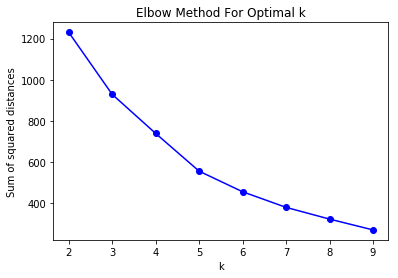

In [28]:
x_kmeans = dummy0.iloc[:, 5:].values

sum_of_squared_distances = []
K = range(2,10)
for k in K:
    kmeans = KMeans(n_clusters=k, init='k-means++')
    kmeans = kmeans.fit(x_kmeans)
    sum_of_squared_distances.append(kmeans.inertia_)  #Sum of squared distances of samples to their closest cluster center
    
plt.plot(K, sum_of_squared_distances, 'bo-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [29]:
kmeans = KMeans(n_clusters=3, init='k-means++')
kmeans.fit(x_kmeans)
y_kmeans = kmeans.predict(x_kmeans)

print(y_kmeans)

[1 0 0 ... 0 1 0]


# Add description key words as new columns

In [30]:
dummy_keywords = pd.read_csv('/Users/yinghua/Documents/dummy_data_allclean.csv')

In [31]:
dummy_keywords.columns

Index(['Unnamed: 0', 'Salary', 'Job_class', 'Experience', 'Salary.1',
       'Job_class.1', 'Experience.1', 'data', 'statistique', 'analyse',
       ...
       'Contract_intérim', 'Location_33', 'Location_44', 'Location_69',
       'Location_75', 'Salary_range_3bins', 'Salary_range_4bins',
       'Salary_range_5bins', 'Salary_range_qcut_4bins',
       'Salary_range_qcut_3bins'],
      dtype='object', length=126)

In [32]:
dummy_keywords.shape

(1669, 126)

In [34]:
dummy_keywords = dummy_keywords.drop(['Unnamed: 0', 'Salary', 'Job_class', 'Experience', 'Salary.1',
       'Job_class.1', 'Experience.1', 'Contract_cdi', 'Contract_freelance / indépendant', 
        'Contract_intérim', 'Location_33', 'Location_44', 'Location_69',
       'Location_75', 'Salary_range_3bins', 'Salary_range_4bins',
       'Salary_range_5bins', 'Salary_range_qcut_4bins',
       'Salary_range_qcut_3bins'], axis = 1)

dummy1 = pd.concat([dummy0, dummy_keywords], axis = 1)

In [35]:
dummy1.columns

Index(['Salary', 'Salary_group_cut3', 'Salary_group_cut4',
       'Salary_group_qcut3', 'Salary_group_qcut4', 'Job_class', 'Experience',
       'Contract_cdi', 'Contract_freelance / indépendant', 'Contract_intérim',
       ...
       'assurance', 'transport', 'fintech', 'santé', 'luxe', 'bancaire',
       'anglais', 'agile', 'international', 'startup'],
      dtype='object', length=121)

In [37]:
dummy1.shape

(1669, 121)

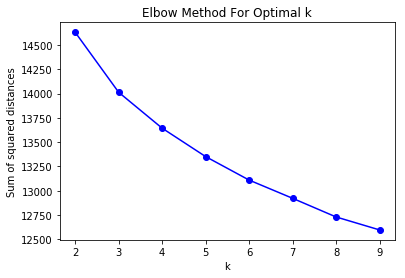

In [71]:
x_kmeans = dummy1.iloc[:, 5:].values

sum_of_squared_distances = []
K = range(2,10)
for k in K:
    kmeans = KMeans(n_clusters=k, init='k-means++')
    kmeans = kmeans.fit(x_kmeans)
    sum_of_squared_distances.append(kmeans.inertia_)  #Sum of squared distances of samples to their closest cluster center
    
plt.plot(K, sum_of_squared_distances, 'bo-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

# cut=3, all columns 

In [38]:
x = dummy1.iloc[:, 5:]
y = dummy1['Salary_group_cut3']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state=0)

lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)
print('LogisticRegression score: ', lr.score(x_test, y_test))
print('LogisticRegression train_set score: ', lr.score(x_train, y_train))
print('LogisticRegression f1: ', f1_score(y_test, lr.predict(x_test), average='weighted'))

svm = SVC(kernel = 'linear', random_state=0)
svm.fit(x_train, y_train)
print('\nSVM Linear score: ', svm.score(x_test, y_test))
print('SVM Linear train_set score: ', svm.score(x_train, y_train))
print('SVM Linear f1: ', f1_score(y_test, svm.predict(x_test), average='weighted'))

rbf = SVC(kernel='rbf', random_state=0)
rbf.fit(x_train, y_train)
print('\nSVM RBF score: ', rbf.score(x_test, y_test))
print('SVM RBF train_set score: ', rbf.score(x_train, y_train))
print('SVM RBF f1: ', f1_score(y_test, rbf.predict(x_test), average='weighted'))

tree = DecisionTreeClassifier(random_state=0)
tree.fit(x_train, y_train)
print('\nDC score: ', tree.score(x_test, y_test))
print('DC train_set score: ', tree.score(x_train, y_train))
print('DC f1: ', f1_score(y_test, tree.predict(x_test), average='weighted'))

rf = RandomForestClassifier(random_state=0)
rf.fit(x_train, y_train)
print('\nRF score: ', rf.score(x_test, y_test))
print('RF train_set score: ', rf.score(x_train, y_train))
print('RF f1: ', f1_score(y_test, rf.predict(x_test), average='weighted'))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


LogisticRegression score:  0.7544910179640718
LogisticRegression train_set score:  0.761986301369863
LogisticRegression f1:  0.7487426525527948

SVM Linear score:  0.7644710578842315
SVM Linear train_set score:  0.7799657534246576
SVM Linear f1:  0.7569155072851668


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



SVM RBF score:  0.7584830339321357
SVM RBF train_set score:  0.7337328767123288
SVM RBF f1:  0.7394461917915012

DC score:  0.6706586826347305
DC train_set score:  0.9965753424657534
DC f1:  0.6773390359691351

RF score:  0.7265469061876247
RF train_set score:  0.9845890410958904
RF f1:  0.7131202253194088


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# cut=4, all columns 

In [39]:
x = dummy1.iloc[:, 5:]
y = dummy1['Salary_group_cut4']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state=0)

lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)
print('LogisticRegression score: ', lr.score(x_test, y_test))
print('LogisticRegression train_set score: ', lr.score(x_train, y_train))
print('LogisticRegression f1: ', f1_score(y_test, lr.predict(x_test), average='weighted'))

svm = SVC(kernel = 'linear', random_state=0)
svm.fit(x_train, y_train)
print('\nSVM Linear score: ', svm.score(x_test, y_test))
print('SVM Linear train_set score: ', svm.score(x_train, y_train))
print('SVM Linear f1: ', f1_score(y_test, svm.predict(x_test), average='weighted'))

rbf = SVC(kernel='rbf', random_state=0)
rbf.fit(x_train, y_train)
print('\nSVM RBF score: ', rbf.score(x_test, y_test))
print('SVM RBF train_set score: ', rbf.score(x_train, y_train))
print('SVM RBF f1: ', f1_score(y_test, rbf.predict(x_test), average='weighted'))

tree = DecisionTreeClassifier(random_state=0)
tree.fit(x_train, y_train)
print('\nDC score: ', tree.score(x_test, y_test))
print('DC train_set score: ', tree.score(x_train, y_train))
print('DC f1: ', f1_score(y_test, tree.predict(x_test), average='weighted'))

rf = RandomForestClassifier(random_state=0)
rf.fit(x_train, y_train)
print('\nRF score: ', rf.score(x_test, y_test))
print('RF train_set score: ', rf.score(x_train, y_train))
print('RF f1: ', f1_score(y_test, rf.predict(x_test), average='weighted'))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression score:  0.6706586826347305
LogisticRegression train_set score:  0.7029109589041096
LogisticRegression f1:  0.6364910259862956

SVM Linear score:  0.6427145708582834
SVM Linear train_set score:  0.735445205479452
SVM Linear f1:  0.619490191959909


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



SVM RBF score:  0.6407185628742516
SVM RBF train_set score:  0.625
SVM RBF f1:  0.500415227938284

DC score:  0.5948103792415169
DC train_set score:  0.9940068493150684
DC f1:  0.5977746969424984

RF score:  0.6586826347305389
RF train_set score:  0.9717465753424658
RF f1:  0.6366354947902605


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


# qcut = 3, all columns

In [40]:
x = dummy1.iloc[:, 5:]
y = dummy1['Salary_group_qcut3']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state=0)

lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)
print('LogisticRegression score: ', lr.score(x_test, y_test))
print('LogisticRegression train_set score: ', lr.score(x_train, y_train))
print('LogisticRegression f1: ', f1_score(y_test, lr.predict(x_test), average='weighted'))

svm = SVC(kernel = 'linear', random_state=0)
svm.fit(x_train, y_train)
print('\nSVM Linear score: ', svm.score(x_test, y_test))
print('SVM Linear train_set score: ', svm.score(x_train, y_train))
print('SVM Linear f1: ', f1_score(y_test, svm.predict(x_test), average='weighted'))

rbf = SVC(kernel='rbf', random_state=0)
rbf.fit(x_train, y_train)
print('\nSVM RBF score: ', rbf.score(x_test, y_test))
print('SVM RBF train_set score: ', rbf.score(x_train, y_train))
print('SVM RBF f1: ', f1_score(y_test, rbf.predict(x_test), average='weighted'))

tree = DecisionTreeClassifier(random_state=0)
tree.fit(x_train, y_train)
print('\nDC score: ', tree.score(x_test, y_test))
print('DC train_set score: ', tree.score(x_train, y_train))
print('DC f1: ', f1_score(y_test, tree.predict(x_test), average='weighted'))

rf = RandomForestClassifier(random_state=0)
rf.fit(x_train, y_train)
print('\nRF score: ', rf.score(x_test, y_test))
print('RF train_set score: ', rf.score(x_train, y_train))
print('RF f1: ', f1_score(y_test, rf.predict(x_test), average='weighted'))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression score:  0.5748502994011976
LogisticRegression train_set score:  0.6378424657534246
LogisticRegression f1:  0.5658827374813086

SVM Linear score:  0.5728542914171657
SVM Linear train_set score:  0.6678082191780822
SVM Linear f1:  0.5675230928621607


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



SVM RBF score:  0.6027944111776448
SVM RBF train_set score:  0.5924657534246576
SVM RBF f1:  0.596237733683406

DC score:  0.5149700598802395
DC train_set score:  0.9957191780821918
DC f1:  0.515155211389417

RF score:  0.5848303393213573
RF train_set score:  0.985445205479452
RF f1:  0.5786983055248421


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


# qcut=4, all columns

In [41]:
x = dummy1.iloc[:, 5:]
y = dummy1['Salary_group_qcut4']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state=0)

lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)
print('LogisticRegression score: ', lr.score(x_test, y_test))
print('LogisticRegression train_set score: ', lr.score(x_train, y_train))
print('LogisticRegression f1: ', f1_score(y_test, lr.predict(x_test), average='weighted'))

svm = SVC(kernel = 'linear', random_state=0)
svm.fit(x_train, y_train)
print('\nSVM Linear score: ', svm.score(x_test, y_test))
print('SVM Linear train_set score: ', svm.score(x_train, y_train))
print('SVM Linear f1: ', f1_score(y_test, svm.predict(x_test), average='weighted'))

rbf = SVC(kernel='rbf', random_state=0)
rbf.fit(x_train, y_train)
print('\nSVM RBF score: ', rbf.score(x_test, y_test))
print('SVM RBF train_set score: ', rbf.score(x_train, y_train))
print('SVM RBF f1: ', f1_score(y_test, rbf.predict(x_test), average='weighted'))

tree = DecisionTreeClassifier(random_state=0)
tree.fit(x_train, y_train)
print('\nDC score: ', tree.score(x_test, y_test))
print('DC train_set score: ', tree.score(x_train, y_train))
print('DC f1: ', f1_score(y_test, tree.predict(x_test), average='weighted'))

rf = RandomForestClassifier(random_state=0)
rf.fit(x_train, y_train)
print('\nRF score: ', rf.score(x_test, y_test))
print('RF train_set score: ', rf.score(x_train, y_train))
print('RF f1: ', f1_score(y_test, rf.predict(x_test), average='weighted'))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression score:  0.500998003992016
LogisticRegression train_set score:  0.5676369863013698
LogisticRegression f1:  0.48639562992711394

SVM Linear score:  0.47904191616766467
SVM Linear train_set score:  0.5950342465753424
SVM Linear f1:  0.4624202949762358


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



SVM RBF score:  0.499001996007984
SVM RBF train_set score:  0.4974315068493151
SVM RBF f1:  0.44993467294440015

DC score:  0.41916167664670656
DC train_set score:  0.9922945205479452
DC f1:  0.4161532022803636

RF score:  0.48502994011976047
RF train_set score:  0.9777397260273972
RF f1:  0.4782391963418588


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


# PCA bin =3 

In [42]:
x = dummy1.iloc[:, 5:]
y = dummy1['Salary_group_cut3']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state=0)

pca = PCA(.95, random_state=0)
pca.fit(x_train)
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)
print('PCA: ', pca.explained_variance_ratio_)

lr = LogisticRegression(random_state=0)
lr.fit(x_train_pca, y_train)
print('\nLogisticRegression score: ', lr.score(x_test_pca, y_test))
print('LogisticRegression train_set score: ', lr.score(x_train_pca, y_train))
print('LogisticRegression f1: ', f1_score(y_test, lr.predict(x_test_pca), average='weighted'))

svm = SVC(kernel = 'linear', random_state=0)
svm.fit(x_train_pca, y_train)
print('\nSVM Linear score: ', svm.score(x_test_pca, y_test))
print('SVM Linear train_set score: ', svm.score(x_train_pca, y_train))
print('SVM Linear f1: ', f1_score(y_test, svm.predict(x_test_pca), average='weighted'))

rbf = SVC(kernel='rbf', random_state=0)
rbf.fit(x_train_pca, y_train)
print('\nSVM RBF score: ', rbf.score(x_test_pca, y_test))
print('SVM RBF train_set score: ', rbf.score(x_train_pca, y_train))
print('SVM RBF f1: ', f1_score(y_test, rbf.predict(x_test_pca), average='weighted'))

tree = DecisionTreeClassifier(random_state=0)
tree.fit(x_train_pca, y_train)
print('\nDC score: ', tree.score(x_test_pca, y_test))
print('DC train_set score: ', tree.score(x_train_pca, y_train))
print('DC f1: ', f1_score(y_test, tree.predict(x_test_pca), average='weighted'))

rf = RandomForestClassifier(random_state=0)
rf.fit(x_train_pca, y_train)
print('\nRF score: ', rf.score(x_test_pca, y_test))
print('RF train_set score: ', rf.score(x_train_pca, y_train))
print('RF f1: ', f1_score(y_test, rf.predict(x_test_pca), average='weighted'))


PCA:  [0.08941536 0.05115656 0.04610649 0.0452275  0.03541827 0.03309695
 0.03032496 0.02785574 0.02631826 0.02549619 0.02366969 0.02158153
 0.02105254 0.02013631 0.02000098 0.01869764 0.01812942 0.01767364
 0.01649874 0.01573596 0.01549681 0.01464831 0.01377656 0.01329028
 0.01297843 0.01244221 0.01236466 0.01148312 0.01127577 0.01065541
 0.01005191 0.00970893 0.00930719 0.00907566 0.00884609 0.00844992
 0.00831148 0.00807886 0.00794978 0.00737918 0.00717081 0.00694153
 0.00673333 0.00661996 0.00649734 0.00624234 0.00589841 0.00578115
 0.00574001 0.0056715  0.00541722 0.00520967 0.0049535  0.00489157
 0.0048066  0.00458755 0.00453271 0.00425615 0.00415285 0.00397411
 0.0038575  0.00354023 0.00335387 0.00317863 0.00311847 0.00297102
 0.00287355]

LogisticRegression score:  0.7524950099800399
LogisticRegression train_set score:  0.7414383561643836
LogisticRegression f1:  0.7469172848760406

SVM Linear score:  0.7465069860279441


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


SVM Linear train_set score:  0.7602739726027398
SVM Linear f1:  0.7400266118364176

SVM RBF score:  0.7604790419161677


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVM RBF train_set score:  0.7414383561643836
SVM RBF f1:  0.7453001644618411

DC score:  0.6646706586826348
DC train_set score:  0.9965753424657534
DC f1:  0.6650761634066054

RF score:  0.7065868263473054
RF train_set score:  0.9708904109589042
RF f1:  0.6790752716061352


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# PCA BIN=4

In [43]:
x = dummy1.iloc[:, 5:]
y = dummy1['Salary_group_cut4']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state=0)

pca = PCA(.95, random_state=0)
pca.fit(x_train)
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

lr = LogisticRegression(random_state=0)
lr.fit(x_train_pca, y_train)
print('LogisticRegression score: ', lr.score(x_test_pca, y_test))
print('LogisticRegression train_set score: ', lr.score(x_train_pca, y_train))
print('LogisticRegression f1: ', f1_score(y_test, lr.predict(x_test_pca), average='weighted'))

svm = SVC(kernel = 'linear', random_state=0)
svm.fit(x_train_pca, y_train)
print('\nSVM Linear score: ', svm.score(x_test_pca, y_test))
print('SVM Linear train_set score: ', svm.score(x_train_pca, y_train))
print('SVM Linear f1: ', f1_score(y_test, svm.predict(x_test_pca), average='weighted'))

rbf = SVC(kernel='rbf', random_state=0)
rbf.fit(x_train_pca, y_train)
print('\nSVM RBF score: ', rbf.score(x_test_pca, y_test))
print('SVM RBF train_set score: ', rbf.score(x_train_pca, y_train))
print('SVM RBF f1: ', f1_score(y_test, rbf.predict(x_test_pca), average='weighted'))

tree = DecisionTreeClassifier(random_state=0)
tree.fit(x_train_pca, y_train)
print('\nDC score: ', tree.score(x_test_pca, y_test))
print('DC train_set score: ', tree.score(x_train_pca, y_train))
print('DC f1: ', f1_score(y_test, tree.predict(x_test_pca), average='weighted'))

rf = RandomForestClassifier(random_state=0)
rf.fit(x_train_pca, y_train)
print('\nRF score: ', rf.score(x_test_pca, y_test))
print('RF train_set score: ', rf.score(x_train_pca, y_train))
print('RF f1: ', f1_score(y_test, rf.predict(x_test_pca), average='weighted'))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression score:  0.654690618762475
LogisticRegression train_set score:  0.6832191780821918
LogisticRegression f1:  0.6238284474417072

SVM Linear score:  0.654690618762475
SVM Linear train_set score:  0.6986301369863014
SVM Linear f1:  0.6266648045475471

SVM RBF score:  0.6586826347305389


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVM RBF train_set score:  0.6669520547945206
SVM RBF f1:  0.5646568464584073

DC score:  0.5548902195608783
DC train_set score:  0.9940068493150684
DC f1:  0.5544490755017427

RF score:  0.6307385229540918
RF train_set score:  0.9777397260273972
RF f1:  0.5970154068132827


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


# PCA qcut = 3

In [44]:
x = dummy1.iloc[:, 5:]
y = dummy1['Salary_group_qcut3']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state=0)

pca = PCA(.95, random_state=0)
pca.fit(x_train)
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

lr = LogisticRegression(random_state=0)
lr.fit(x_train_pca, y_train)
print('LogisticRegression score: ', lr.score(x_test_pca, y_test))
print('LogisticRegression train_set score: ', lr.score(x_train_pca, y_train))
print('LogisticRegression f1: ', f1_score(y_test, lr.predict(x_test_pca), average='weighted'))

svm = SVC(kernel = 'linear', random_state=0)
svm.fit(x_train_pca, y_train)
print('\nSVM Linear score: ', svm.score(x_test_pca, y_test))
print('SVM Linear train_set score: ', svm.score(x_train_pca, y_train))
print('SVM Linear f1: ', f1_score(y_test, svm.predict(x_test_pca), average='weighted'))

rbf = SVC(kernel='rbf', random_state=0)
rbf.fit(x_train_pca, y_train)
print('\nSVM RBF score: ', rbf.score(x_test_pca, y_test))
print('SVM RBF train_set score: ', rbf.score(x_train_pca, y_train))
print('SVM RBF f1: ', f1_score(y_test, rbf.predict(x_test_pca), average='weighted'))

tree = DecisionTreeClassifier(random_state=0)
tree.fit(x_train_pca, y_train)
print('\nDC score: ', tree.score(x_test_pca, y_test))
print('DC train_set score: ', tree.score(x_train_pca, y_train))
print('DC f1: ', f1_score(y_test, tree.predict(x_test_pca), average='weighted'))

rf = RandomForestClassifier(random_state=0)
rf.fit(x_train_pca, y_train)
print('\nRF score: ', rf.score(x_test_pca, y_test))
print('RF train_set score: ', rf.score(x_train_pca, y_train))
print('RF f1: ', f1_score(y_test, rf.predict(x_test_pca), average='weighted'))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression score:  0.5768463073852296
LogisticRegression train_set score:  0.615582191780822
LogisticRegression f1:  0.5636234441228517

SVM Linear score:  0.5808383233532934
SVM Linear train_set score:  0.627568493150685
SVM Linear f1:  0.572314690739257


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



SVM RBF score:  0.5948103792415169
SVM RBF train_set score:  0.6053082191780822
SVM RBF f1:  0.5917927360234245

DC score:  0.48303393213572854
DC train_set score:  0.9957191780821918
DC f1:  0.48221602486868403

RF score:  0.5449101796407185
RF train_set score:  0.9777397260273972
RF f1:  0.5320925759816401


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


# PCA qcut = 4

In [45]:
x = dummy1.iloc[:, 5:]
y = dummy1['Salary_group_qcut4']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state=0)

pca = PCA(.95, random_state=0)
pca.fit(x_train)
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

lr = LogisticRegression(random_state=0)
lr.fit(x_train_pca, y_train)
print('LogisticRegression score: ', lr.score(x_test_pca, y_test))
print('LogisticRegression train_set score: ', lr.score(x_train_pca, y_train))
print('LogisticRegression f1: ', f1_score(y_test, lr.predict(x_test_pca), average='weighted'))

svm = SVC(kernel = 'linear', random_state=0)
svm.fit(x_train_pca, y_train)
print('\nSVM Linear score: ', svm.score(x_test_pca, y_test))
print('SVM Linear train_set score: ', svm.score(x_train_pca, y_train))
print('SVM Linear f1: ', f1_score(y_test, svm.predict(x_test_pca), average='weighted'))

rbf = SVC(kernel='rbf', random_state=0)
rbf.fit(x_train_pca, y_train)
print('\nSVM RBF score: ', rbf.score(x_test_pca, y_test))
print('SVM RBF train_set score: ', rbf.score(x_train_pca, y_train))
print('SVM RBF f1: ', f1_score(y_test, rbf.predict(x_test_pca), average='weighted'))

tree = DecisionTreeClassifier(random_state=0)
tree.fit(x_train_pca, y_train)
print('\nDC score: ', tree.score(x_test_pca, y_test))
print('DC train_set score: ', tree.score(x_train_pca, y_train))
print('DC f1: ', f1_score(y_test, tree.predict(x_test_pca), average='weighted'))

rf = RandomForestClassifier(random_state=0)
rf.fit(x_train_pca, y_train)
print('\nRF score: ', rf.score(x_test_pca, y_test))
print('RF train_set score: ', rf.score(x_train_pca, y_train))
print('RF f1: ', f1_score(y_test, rf.predict(x_test_pca), average='weighted'))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression score:  0.46706586826347307
LogisticRegression train_set score:  0.5402397260273972
LogisticRegression f1:  0.44859524251537436

SVM Linear score:  0.45708582834331335
SVM Linear train_set score:  0.5573630136986302
SVM Linear f1:  0.44130720930183703


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



SVM RBF score:  0.49500998003992014
SVM RBF train_set score:  0.5042808219178082
SVM RBF f1:  0.45485250025295115

DC score:  0.3932135728542914
DC train_set score:  0.9922945205479452
DC f1:  0.39143556867279433

RF score:  0.4251497005988024
RF train_set score:  0.9794520547945206
RF f1:  0.41363584968863853


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


# RFE cut = 3

In [63]:
x = dummy1.iloc[:, 5:]
y = dummy1['Salary_group_cut3']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state=0)

estimator = LogisticRegression(multi_class = 'auto', solver = 'newton-cg', random_state = 0)
selector1 = RFE(estimator, 80, step=1)
selector1 = selector1.fit(x_train, y_train) 
print('LogisticRegression score: ', selector1.score(x_test, y_test))
print('LogisticRegression train_set score: ', selector1.score(x_train, y_train))
print('LogisticRegression f1: ', f1_score(y_test, selector1.predict(x_test), average='weighted'))
col_lr_80 = dummy1.iloc[:, 5:].columns[selector1.get_support()]
#print('RFE result for lr: ', col_lr_80)
selector2 = RFE(estimator, 50, step=1)
selector2 = selector2.fit(x_train, y_train) 
print('\nLogisticRegression score: ', selector2.score(x_test, y_test))
print('LogisticRegression train_set score: ', selector2.score(x_train, y_train))
print('LogisticRegression f1: ', f1_score(y_test, selector2.predict(x_test), average='weighted'))
col_lr_50 = dummy1.iloc[:, 5:].columns[selector2.get_support()]
#print('RFE result for lr: ', col_lr_50)
selector3 = RFE(estimator, 30, step=1)
selector3 = selector3.fit(x_train, y_train) 
print('\nLogisticRegression score: ', selector3.score(x_test, y_test))
print('LogisticRegression train_set score: ', selector3.score(x_train, y_train))
print('LogisticRegression f1: ', f1_score(y_test, selector3.predict(x_test), average='weighted'))
col_lr_30 = dummy1.iloc[:, 5:].columns[selector3.get_support()]
#print('RFE result for lr: ', col_lr_30)

estimator = SVC(kernel = "linear", random_state = 0)
selector1 = RFE(estimator, 80, step=1)
selector1 = selector1.fit(x_train, y_train)
print('\nSVC Linear score: ', selector1.score(x_test, y_test))
print('SVC Linear train_set score: ', selector1.score(x_train, y_train))
print('SVC Linear f1: ', f1_score(y_test, selector1.predict(x_test), average='weighted'))
col_svc_80 = dummy1.iloc[:, 5:].columns[selector1.get_support()]
#print('RFE result for svc linear: ', col_svc)
selector2 = RFE(estimator, 50, step=1)
selector2 = selector2.fit(x_train, y_train) 
print('\nSVC Linear score: ', selector2.score(x_test, y_test))
print('SVC Linear train_set score: ', selector2.score(x_train, y_train))
print('SVC Linear f1: ', f1_score(y_test, selector2.predict(x_test), average='weighted'))
col_svc_50 = dummy1.iloc[:, 5:].columns[selector2.get_support()]
#print('RFE result for svc linear: ', col_svc)
selector3 = RFE(estimator, 30, step=1)
selector3 = selector3.fit(x_train, y_train) 
print('\nSVC Linear score: ', selector3.score(x_test, y_test))
print('SVC Linear train_set score: ', selector3.score(x_train, y_train))
print('SVC Linear f1: ', f1_score(y_test, selector3.predict(x_test), average='weighted'))
col_svc_30 = dummy1.iloc[:, 5:].columns[selector3.get_support()]
#print('RFE result for svc linear: ', col_svc)

#estimator = SVC(kernel = 'rbf', random_state=0)
#selector = RFE(estimator, 80, step=1)
#selector = selector.fit(x_train, y_train) 
#col_rbf = dummy1.iloc[:, 5:].columns[selector.get_support()]
#### The classifier does not expose "coef_" or "feature_importances_" attributes

estimator = DecisionTreeClassifier(random_state=0)
selector1 = RFE(estimator, 80, step=1)
selector1 = selector1.fit(x_train, y_train) 
print('\nDecision Tree score: ', selector1.score(x_test, y_test))
print('Decision Tree train_set score: ', selector1.score(x_train, y_train))
print('Decision Tree f1: ', f1_score(y_test, selector1.predict(x_test), average='weighted'))
col_dt_80 = dummy1.iloc[:, 5:].columns[selector1.get_support()]
#print('RFE result for dt: ', col_dt)
selector2 = RFE(estimator, 50, step=1)
selector2 = selector2.fit(x_train, y_train) 
print('\nDecision Tree score: ', selector2.score(x_test, y_test))
print('Decision Tree train_set score: ', selector2.score(x_train, y_train))
print('Decision Tree f1: ', f1_score(y_test, selector2.predict(x_test), average='weighted'))
col_dt_50 = dummy1.iloc[:, 5:].columns[selector2.get_support()]
#print('RFE result for lr: ', col_lr_50)
selector3 = RFE(estimator, 30, step=1)
selector3 = selector3.fit(x_train, y_train) 
print('\nDecision Tree score: ', selector3.score(x_test, y_test))
print('Decision Tree train_set score: ', selector3.score(x_train, y_train))
print('Decision Tree f1: ', f1_score(y_test, selector3.predict(x_test), average='weighted'))
col_dt_30 = dummy1.iloc[:, 5:].columns[selector3.get_support()]
#print('RFE result for lr: ', col_lr_30)

estimator = RandomForestClassifier(n_estimators = 100, random_state=0)
selector1 = RFE(estimator, 80, step=1)
selector1 = selector1.fit(x_train, y_train) 
print('\nRF score: ', selector1.score(x_test, y_test))
print('RF train_set score: ', selector1.score(x_train, y_train))
print('RF f1: ', f1_score(y_test, selector1.predict(x_test), average='weighted'))
col_rf_80 = dummy1.iloc[:, 5:].columns[selector1.get_support()]
#print('RFE result for dt: ', col_dt)
selector2 = RFE(estimator, 50, step=1)
selector2 = selector2.fit(x_train, y_train) 
print('\nRF score: ', selector2.score(x_test, y_test))
print('RF train_set score: ', selector2.score(x_train, y_train))
print('RF f1: ', f1_score(y_test, selector2.predict(x_test), average='weighted'))
col_dt_50 = dummy1.iloc[:, 5:].columns[selector2.get_support()]
#print('RFE result for lr: ', col_lr_50)
selector3 = RFE(estimator, 30, step=1)
selector3 = selector3.fit(x_train, y_train) 
print('\nRF score: ', selector3.score(x_test, y_test))
print('RF train_set score: ', selector3.score(x_train, y_train))
print('RF f1: ', f1_score(y_test, selector3.predict(x_test), average='weighted'))
col_dt_30 = dummy1.iloc[:, 5:].columns[selector3.get_support()]
#print('RFE result for lr: ', col_lr_30)

LogisticRegression score:  0.7684630738522954
LogisticRegression train_set score:  0.7636986301369864
LogisticRegression f1:  0.7642912461360433

LogisticRegression score:  0.7405189620758483
LogisticRegression train_set score:  0.7517123287671232
LogisticRegression f1:  0.7367471846430597

LogisticRegression score:  0.7445109780439122
LogisticRegression train_set score:  0.7422945205479452
LogisticRegression f1:  0.7411869165414077

SVC Linear score:  0.7664670658682635
SVC Linear train_set score:  0.7696917808219178
SVC Linear f1:  0.7599215982449516

SVC Linear score:  0.7644710578842315
SVC Linear train_set score:  0.752568493150685
SVC Linear f1:  0.7563718334475328

SVC Linear score:  0.7524950099800399
SVC Linear train_set score:  0.738013698630137
SVC Linear f1:  0.7393559550030495


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Decision Tree score:  0.6746506986027944
Decision Tree train_set score:  0.9965753424657534
Decision Tree f1:  0.6808591956180623

Decision Tree score:  0.6766467065868264
Decision Tree train_set score:  0.9957191780821918
Decision Tree f1:  0.6855351312267458

Decision Tree score:  0.6746506986027944
Decision Tree train_set score:  0.9922945205479452
Decision Tree f1:  0.6772545852058451

RF score:  0.7684630738522954
RF train_set score:  0.9965753424657534
RF f1:  0.7592444220391169


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



RF score:  0.7485029940119761
RF train_set score:  0.9957191780821918
RF f1:  0.7424247996167235


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



RF score:  0.7584830339321357
RF train_set score:  0.9940068493150684
RF f1:  0.7501467188440547


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
#rfe_result = pd.DataFrame({'lr': list(col_lr), 'svc': list(col_svc), 'dt': list(col_dt), 'rf': list(col_rf)}, 
#                          columns = ['lr', 'svc', 'dt', 'rf']
#                          )

# RFE cut = 4

In [64]:
x = dummy1.iloc[:, 5:]
y = dummy1['Salary_group_cut4']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state=0)

estimator = LogisticRegression(multi_class = 'auto', solver = 'newton-cg', random_state = 0)
selector1 = RFE(estimator, 80, step=1)
selector1 = selector1.fit(x_train, y_train) 
print('LogisticRegression score: ', selector1.score(x_test, y_test))
print('LogisticRegression train_set score: ', selector1.score(x_train, y_train))
print('LogisticRegression f1: ', f1_score(y_test, selector1.predict(x_test), average='weighted'))
col_lr_80 = dummy1.iloc[:, 5:].columns[selector1.get_support()]
#print('RFE result for lr: ', col_lr_80)
selector2 = RFE(estimator, 50, step=1)
selector2 = selector2.fit(x_train, y_train) 
print('\nLogisticRegression score: ', selector2.score(x_test, y_test))
print('LogisticRegression train_set score: ', selector2.score(x_train, y_train))
print('LogisticRegression f1: ', f1_score(y_test, selector2.predict(x_test), average='weighted'))
col_lr_50 = dummy1.iloc[:, 5:].columns[selector2.get_support()]
#print('RFE result for lr: ', col_lr_50)
selector3 = RFE(estimator, 30, step=1)
selector3 = selector3.fit(x_train, y_train) 
print('\nLogisticRegression score: ', selector3.score(x_test, y_test))
print('LogisticRegression train_set score: ', selector3.score(x_train, y_train))
print('LogisticRegression f1: ', f1_score(y_test, selector3.predict(x_test), average='weighted'))
col_lr_30 = dummy1.iloc[:, 5:].columns[selector3.get_support()]
#print('RFE result for lr: ', col_lr_30)

estimator = SVC(kernel = "linear", random_state = 0)
selector1 = RFE(estimator, 80, step=1)
selector1 = selector1.fit(x_train, y_train)
print('\nSVC Linear score: ', selector1.score(x_test, y_test))
print('SVC Linear train_set score: ', selector1.score(x_train, y_train))
print('SVC Linear f1: ', f1_score(y_test, selector1.predict(x_test), average='weighted'))
col_svc_80 = dummy1.iloc[:, 5:].columns[selector1.get_support()]
#print('RFE result for svc linear: ', col_svc)
selector2 = RFE(estimator, 50, step=1)
selector2 = selector2.fit(x_train, y_train) 
print('\nSVC Linear score: ', selector2.score(x_test, y_test))
print('SVC Linear train_set score: ', selector2.score(x_train, y_train))
print('SVC Linear f1: ', f1_score(y_test, selector2.predict(x_test), average='weighted'))
col_svc_50 = dummy1.iloc[:, 5:].columns[selector2.get_support()]
#print('RFE result for svc linear: ', col_svc)
selector3 = RFE(estimator, 30, step=1)
selector3 = selector3.fit(x_train, y_train) 
print('\nSVC Linear score: ', selector3.score(x_test, y_test))
print('SVC Linear train_set score: ', selector3.score(x_train, y_train))
print('SVC Linear f1: ', f1_score(y_test, selector3.predict(x_test), average='weighted'))
col_svc_30 = dummy1.iloc[:, 5:].columns[selector3.get_support()]
#print('RFE result for svc linear: ', col_svc)

#estimator = SVC(kernel = 'rbf', random_state=0)
#selector = RFE(estimator, 80, step=1)
#selector = selector.fit(x_train, y_train) 
#col_rbf = dummy1.iloc[:, 5:].columns[selector.get_support()]
#### The classifier does not expose "coef_" or "feature_importances_" attributes

estimator = DecisionTreeClassifier(random_state=0)
selector1 = RFE(estimator, 80, step=1)
selector1 = selector1.fit(x_train, y_train) 
print('\nDecision Tree score: ', selector1.score(x_test, y_test))
print('Decision Tree train_set score: ', selector1.score(x_train, y_train))
print('Decision Tree f1: ', f1_score(y_test, selector1.predict(x_test), average='weighted'))
col_dt_80 = dummy1.iloc[:, 5:].columns[selector1.get_support()]
#print('RFE result for dt: ', col_dt)
selector2 = RFE(estimator, 50, step=1)
selector2 = selector2.fit(x_train, y_train) 
print('\nDecision Tree score: ', selector2.score(x_test, y_test))
print('Decision Tree train_set score: ', selector2.score(x_train, y_train))
print('Decision Tree f1: ', f1_score(y_test, selector2.predict(x_test), average='weighted'))
col_dt_50 = dummy1.iloc[:, 5:].columns[selector2.get_support()]
#print('RFE result for lr: ', col_lr_50)
selector3 = RFE(estimator, 30, step=1)
selector3 = selector3.fit(x_train, y_train) 
print('\nDecision Tree score: ', selector3.score(x_test, y_test))
print('Decision Tree train_set score: ', selector3.score(x_train, y_train))
print('Decision Tree f1: ', f1_score(y_test, selector3.predict(x_test), average='weighted'))
col_dt_30 = dummy1.iloc[:, 5:].columns[selector3.get_support()]
#print('RFE result for lr: ', col_lr_30)

estimator = RandomForestClassifier(n_estimators = 100, random_state=0)
selector1 = RFE(estimator, 80, step=1)
selector1 = selector1.fit(x_train, y_train) 
print('\nRF score: ', selector1.score(x_test, y_test))
print('RF train_set score: ', selector1.score(x_train, y_train))
print('RF f1: ', f1_score(y_test, selector1.predict(x_test), average='weighted'))
col_rf_80 = dummy1.iloc[:, 5:].columns[selector1.get_support()]
#print('RFE result for dt: ', col_dt)
selector2 = RFE(estimator, 50, step=1)
selector2 = selector2.fit(x_train, y_train) 
print('\nRF score: ', selector2.score(x_test, y_test))
print('RF train_set score: ', selector2.score(x_train, y_train))
print('RF f1: ', f1_score(y_test, selector2.predict(x_test), average='weighted'))
col_dt_50 = dummy1.iloc[:, 5:].columns[selector2.get_support()]
#print('RFE result for lr: ', col_lr_50)
selector3 = RFE(estimator, 30, step=1)
selector3 = selector3.fit(x_train, y_train) 
print('\nRF score: ', selector3.score(x_test, y_test))
print('RF train_set score: ', selector3.score(x_train, y_train))
print('RF f1: ', f1_score(y_test, selector3.predict(x_test), average='weighted'))
col_dt_30 = dummy1.iloc[:, 5:].columns[selector3.get_support()]
#print('RFE result for lr: ', col_lr_30)

LogisticRegression score:  0.6646706586826348
LogisticRegression train_set score:  0.7200342465753424
LogisticRegression f1:  0.6476098894359276

LogisticRegression score:  0.6586826347305389
LogisticRegression train_set score:  0.7046232876712328
LogisticRegression f1:  0.6339971169798014

LogisticRegression score:  0.6746506986027944
LogisticRegression train_set score:  0.7037671232876712
LogisticRegression f1:  0.6462814716288492

SVC Linear score:  0.6706586826347305
SVC Linear train_set score:  0.728595890410959
SVC Linear f1:  0.6457693605245658


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)



SVC Linear score:  0.6706586826347305
SVC Linear train_set score:  0.6986301369863014
SVC Linear f1:  0.6347253208142317


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)



SVC Linear score:  0.688622754491018
SVC Linear train_set score:  0.6823630136986302
SVC Linear f1:  0.6510128948452301

Decision Tree score:  0.6087824351297405
Decision Tree train_set score:  0.9940068493150684
Decision Tree f1:  0.6113662186658948


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)



Decision Tree score:  0.5748502994011976
Decision Tree train_set score:  0.9922945205479452
Decision Tree f1:  0.5790397795598679


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)



Decision Tree score:  0.5449101796407185
Decision Tree train_set score:  0.9888698630136986
Decision Tree f1:  0.5562543028285228


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)



RF score:  0.6806387225548902
RF train_set score:  0.9940068493150684
RF f1:  0.6464757703561269

RF score:  0.6926147704590818
RF train_set score:  0.9922945205479452
RF f1:  0.6584825019295603

RF score:  0.6726546906187625
RF train_set score:  0.9888698630136986
RF f1:  0.6448837912463852


# RFE qcut=3

In [65]:
x = dummy1.iloc[:, 5:]
y = dummy1['Salary_group_qcut3']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state=0)

estimator = LogisticRegression(multi_class = 'auto', solver = 'newton-cg', random_state = 0)
selector1 = RFE(estimator, 80, step=1)
selector1 = selector1.fit(x_train, y_train) 
print('LogisticRegression score: ', selector1.score(x_test, y_test))
print('LogisticRegression train_set score: ', selector1.score(x_train, y_train))
print('LogisticRegression f1: ', f1_score(y_test, selector1.predict(x_test), average='weighted'))
col_lr_80 = dummy1.iloc[:, 5:].columns[selector1.get_support()]
#print('RFE result for lr: ', col_lr_80)
selector2 = RFE(estimator, 50, step=1)
selector2 = selector2.fit(x_train, y_train) 
print('\nLogisticRegression score: ', selector2.score(x_test, y_test))
print('LogisticRegression train_set score: ', selector2.score(x_train, y_train))
print('LogisticRegression f1: ', f1_score(y_test, selector2.predict(x_test), average='weighted'))
col_lr_50 = dummy1.iloc[:, 5:].columns[selector2.get_support()]
#print('RFE result for lr: ', col_lr_50)
selector3 = RFE(estimator, 30, step=1)
selector3 = selector3.fit(x_train, y_train) 
print('\nLogisticRegression score: ', selector3.score(x_test, y_test))
print('LogisticRegression train_set score: ', selector3.score(x_train, y_train))
print('LogisticRegression f1: ', f1_score(y_test, selector3.predict(x_test), average='weighted'))
col_lr_30 = dummy1.iloc[:, 5:].columns[selector3.get_support()]
#print('RFE result for lr: ', col_lr_30)

estimator = SVC(kernel = "linear", random_state = 0)
selector1 = RFE(estimator, 80, step=1)
selector1 = selector1.fit(x_train, y_train)
print('\nSVC Linear score: ', selector1.score(x_test, y_test))
print('SVC Linear train_set score: ', selector1.score(x_train, y_train))
print('SVC Linear f1: ', f1_score(y_test, selector1.predict(x_test), average='weighted'))
col_svc_80 = dummy1.iloc[:, 5:].columns[selector1.get_support()]
#print('RFE result for svc linear: ', col_svc)
selector2 = RFE(estimator, 50, step=1)
selector2 = selector2.fit(x_train, y_train) 
print('\nSVC Linear score: ', selector2.score(x_test, y_test))
print('SVC Linear train_set score: ', selector2.score(x_train, y_train))
print('SVC Linear f1: ', f1_score(y_test, selector2.predict(x_test), average='weighted'))
col_svc_50 = dummy1.iloc[:, 5:].columns[selector2.get_support()]
#print('RFE result for svc linear: ', col_svc)
selector3 = RFE(estimator, 30, step=1)
selector3 = selector3.fit(x_train, y_train) 
print('\nSVC Linear score: ', selector3.score(x_test, y_test))
print('SVC Linear train_set score: ', selector3.score(x_train, y_train))
print('SVC Linear f1: ', f1_score(y_test, selector3.predict(x_test), average='weighted'))
col_svc_30 = dummy1.iloc[:, 5:].columns[selector3.get_support()]
#print('RFE result for svc linear: ', col_svc)

#estimator = SVC(kernel = 'rbf', random_state=0)
#selector = RFE(estimator, 80, step=1)
#selector = selector.fit(x_train, y_train) 
#col_rbf = dummy1.iloc[:, 5:].columns[selector.get_support()]
#### The classifier does not expose "coef_" or "feature_importances_" attributes

estimator = DecisionTreeClassifier(random_state=0)
selector1 = RFE(estimator, 80, step=1)
selector1 = selector1.fit(x_train, y_train) 
print('\nDecision Tree score: ', selector1.score(x_test, y_test))
print('Decision Tree train_set score: ', selector1.score(x_train, y_train))
print('Decision Tree f1: ', f1_score(y_test, selector1.predict(x_test), average='weighted'))
col_dt_80 = dummy1.iloc[:, 5:].columns[selector1.get_support()]
#print('RFE result for dt: ', col_dt)
selector2 = RFE(estimator, 50, step=1)
selector2 = selector2.fit(x_train, y_train) 
print('\nDecision Tree score: ', selector2.score(x_test, y_test))
print('Decision Tree train_set score: ', selector2.score(x_train, y_train))
print('Decision Tree f1: ', f1_score(y_test, selector2.predict(x_test), average='weighted'))
col_dt_50 = dummy1.iloc[:, 5:].columns[selector2.get_support()]
#print('RFE result for lr: ', col_lr_50)
selector3 = RFE(estimator, 30, step=1)
selector3 = selector3.fit(x_train, y_train) 
print('\nDecision Tree score: ', selector3.score(x_test, y_test))
print('Decision Tree train_set score: ', selector3.score(x_train, y_train))
print('Decision Tree f1: ', f1_score(y_test, selector3.predict(x_test), average='weighted'))
col_dt_30 = dummy1.iloc[:, 5:].columns[selector3.get_support()]
#print('RFE result for lr: ', col_lr_30)

estimator = RandomForestClassifier(n_estimators = 100, random_state=0)
selector1 = RFE(estimator, 80, step=1)
selector1 = selector1.fit(x_train, y_train) 
print('\nRF score: ', selector1.score(x_test, y_test))
print('RF train_set score: ', selector1.score(x_train, y_train))
print('RF f1: ', f1_score(y_test, selector1.predict(x_test), average='weighted'))
col_rf_80 = dummy1.iloc[:, 5:].columns[selector1.get_support()]
#print('RFE result for dt: ', col_dt)
selector2 = RFE(estimator, 50, step=1)
selector2 = selector2.fit(x_train, y_train) 
print('\nRF score: ', selector2.score(x_test, y_test))
print('RF train_set score: ', selector2.score(x_train, y_train))
print('RF f1: ', f1_score(y_test, selector2.predict(x_test), average='weighted'))
col_dt_50 = dummy1.iloc[:, 5:].columns[selector2.get_support()]
#print('RFE result for lr: ', col_lr_50)
selector3 = RFE(estimator, 30, step=1)
selector3 = selector3.fit(x_train, y_train) 
print('\nRF score: ', selector3.score(x_test, y_test))
print('RF train_set score: ', selector3.score(x_train, y_train))
print('RF f1: ', f1_score(y_test, selector3.predict(x_test), average='weighted'))
col_dt_30 = dummy1.iloc[:, 5:].columns[selector3.get_support()]
#print('RFE result for lr: ', col_lr_30)

LogisticRegression score:  0.5748502994011976
LogisticRegression train_set score:  0.6412671232876712
LogisticRegression f1:  0.5675726702236473

LogisticRegression score:  0.5868263473053892
LogisticRegression train_set score:  0.6284246575342466
LogisticRegression f1:  0.5785238151220966

LogisticRegression score:  0.5708582834331337
LogisticRegression train_set score:  0.5804794520547946
LogisticRegression f1:  0.5745111603401701

SVC Linear score:  0.5708582834331337
SVC Linear train_set score:  0.648972602739726
SVC Linear f1:  0.565393002326181

SVC Linear score:  0.590818363273453
SVC Linear train_set score:  0.6207191780821918
SVC Linear f1:  0.5949347836193118

SVC Linear score:  0.5588822355289421
SVC Linear train_set score:  0.5804794520547946
SVC Linear f1:  0.5672953003557196

Decision Tree score:  0.5029940119760479
Decision Tree train_set score:  0.9957191780821918
Decision Tree f1:  0.5011164915188

Decision Tree score:  0.5089820359281437
Decision Tree train_set score:

# RFE qcut=4

In [66]:
x = dummy1.iloc[:, 5:]
y = dummy1['Salary_group_qcut3']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state=0)

estimator = LogisticRegression(multi_class = 'auto', solver = 'newton-cg', random_state = 0)
selector1 = RFE(estimator, 80, step=1)
selector1 = selector1.fit(x_train, y_train) 
print('LogisticRegression score: ', selector1.score(x_test, y_test))
print('LogisticRegression train_set score: ', selector1.score(x_train, y_train))
print('LogisticRegression f1: ', f1_score(y_test, selector1.predict(x_test), average='weighted'))
col_lr_80 = dummy1.iloc[:, 5:].columns[selector1.get_support()]
#print('RFE result for lr: ', col_lr_80)
selector2 = RFE(estimator, 50, step=1)
selector2 = selector2.fit(x_train, y_train) 
print('\nLogisticRegression score: ', selector2.score(x_test, y_test))
print('LogisticRegression train_set score: ', selector2.score(x_train, y_train))
print('LogisticRegression f1: ', f1_score(y_test, selector2.predict(x_test), average='weighted'))
col_lr_50 = dummy1.iloc[:, 5:].columns[selector2.get_support()]
#print('RFE result for lr: ', col_lr_50)
selector3 = RFE(estimator, 30, step=1)
selector3 = selector3.fit(x_train, y_train) 
print('\nLogisticRegression score: ', selector3.score(x_test, y_test))
print('LogisticRegression train_set score: ', selector3.score(x_train, y_train))
print('LogisticRegression f1: ', f1_score(y_test, selector3.predict(x_test), average='weighted'))
col_lr_30 = dummy1.iloc[:, 5:].columns[selector3.get_support()]
#print('RFE result for lr: ', col_lr_30)

estimator = SVC(kernel = "linear", random_state = 0)
selector1 = RFE(estimator, 80, step=1)
selector1 = selector1.fit(x_train, y_train)
print('\nSVC Linear score: ', selector1.score(x_test, y_test))
print('SVC Linear train_set score: ', selector1.score(x_train, y_train))
print('SVC Linear f1: ', f1_score(y_test, selector1.predict(x_test), average='weighted'))
col_svc_80 = dummy1.iloc[:, 5:].columns[selector1.get_support()]
#print('RFE result for svc linear: ', col_svc)
selector2 = RFE(estimator, 50, step=1)
selector2 = selector2.fit(x_train, y_train) 
print('\nSVC Linear score: ', selector2.score(x_test, y_test))
print('SVC Linear train_set score: ', selector2.score(x_train, y_train))
print('SVC Linear f1: ', f1_score(y_test, selector2.predict(x_test), average='weighted'))
col_svc_50 = dummy1.iloc[:, 5:].columns[selector2.get_support()]
#print('RFE result for svc linear: ', col_svc)
selector3 = RFE(estimator, 30, step=1)
selector3 = selector3.fit(x_train, y_train) 
print('\nSVC Linear score: ', selector3.score(x_test, y_test))
print('SVC Linear train_set score: ', selector3.score(x_train, y_train))
print('SVC Linear f1: ', f1_score(y_test, selector3.predict(x_test), average='weighted'))
col_svc_30 = dummy1.iloc[:, 5:].columns[selector3.get_support()]
#print('RFE result for svc linear: ', col_svc)

#estimator = SVC(kernel = 'rbf', random_state=0)
#selector = RFE(estimator, 80, step=1)
#selector = selector.fit(x_train, y_train) 
#col_rbf = dummy1.iloc[:, 5:].columns[selector.get_support()]
#### The classifier does not expose "coef_" or "feature_importances_" attributes

estimator = DecisionTreeClassifier(random_state=0)
selector1 = RFE(estimator, 80, step=1)
selector1 = selector1.fit(x_train, y_train) 
print('\nDecision Tree score: ', selector1.score(x_test, y_test))
print('Decision Tree train_set score: ', selector1.score(x_train, y_train))
print('Decision Tree f1: ', f1_score(y_test, selector1.predict(x_test), average='weighted'))
col_dt_80 = dummy1.iloc[:, 5:].columns[selector1.get_support()]
#print('RFE result for dt: ', col_dt)
selector2 = RFE(estimator, 50, step=1)
selector2 = selector2.fit(x_train, y_train) 
print('\nDecision Tree score: ', selector2.score(x_test, y_test))
print('Decision Tree train_set score: ', selector2.score(x_train, y_train))
print('Decision Tree f1: ', f1_score(y_test, selector2.predict(x_test), average='weighted'))
col_dt_50 = dummy1.iloc[:, 5:].columns[selector2.get_support()]
#print('RFE result for lr: ', col_lr_50)
selector3 = RFE(estimator, 30, step=1)
selector3 = selector3.fit(x_train, y_train) 
print('\nDecision Tree score: ', selector3.score(x_test, y_test))
print('Decision Tree train_set score: ', selector3.score(x_train, y_train))
print('Decision Tree f1: ', f1_score(y_test, selector3.predict(x_test), average='weighted'))
col_dt_30 = dummy1.iloc[:, 5:].columns[selector3.get_support()]
#print('RFE result for lr: ', col_lr_30)

estimator = RandomForestClassifier(n_estimators = 100, random_state=0)
selector1 = RFE(estimator, 80, step=1)
selector1 = selector1.fit(x_train, y_train) 
print('\nRF score: ', selector1.score(x_test, y_test))
print('RF train_set score: ', selector1.score(x_train, y_train))
print('RF f1: ', f1_score(y_test, selector1.predict(x_test), average='weighted'))
col_rf_80 = dummy1.iloc[:, 5:].columns[selector1.get_support()]
#print('RFE result for dt: ', col_dt)
selector2 = RFE(estimator, 50, step=1)
selector2 = selector2.fit(x_train, y_train) 
print('\nRF score: ', selector2.score(x_test, y_test))
print('RF train_set score: ', selector2.score(x_train, y_train))
print('RF f1: ', f1_score(y_test, selector2.predict(x_test), average='weighted'))
col_dt_50 = dummy1.iloc[:, 5:].columns[selector2.get_support()]
#print('RFE result for lr: ', col_lr_50)
selector3 = RFE(estimator, 30, step=1)
selector3 = selector3.fit(x_train, y_train) 
print('\nRF score: ', selector3.score(x_test, y_test))
print('RF train_set score: ', selector3.score(x_train, y_train))
print('RF f1: ', f1_score(y_test, selector3.predict(x_test), average='weighted'))
col_dt_30 = dummy1.iloc[:, 5:].columns[selector3.get_support()]
#print('RFE result for lr: ', col_lr_30)

LogisticRegression score:  0.5748502994011976
LogisticRegression train_set score:  0.6412671232876712
LogisticRegression f1:  0.5675726702236473

LogisticRegression score:  0.5868263473053892
LogisticRegression train_set score:  0.6284246575342466
LogisticRegression f1:  0.5785238151220966

LogisticRegression score:  0.5708582834331337
LogisticRegression train_set score:  0.5804794520547946
LogisticRegression f1:  0.5745111603401701

SVC Linear score:  0.5708582834331337
SVC Linear train_set score:  0.648972602739726
SVC Linear f1:  0.565393002326181

SVC Linear score:  0.590818363273453
SVC Linear train_set score:  0.6207191780821918
SVC Linear f1:  0.5949347836193118

SVC Linear score:  0.5588822355289421
SVC Linear train_set score:  0.5804794520547946
SVC Linear f1:  0.5672953003557196

Decision Tree score:  0.5029940119760479
Decision Tree train_set score:  0.9957191780821918
Decision Tree f1:  0.5011164915188

Decision Tree score:  0.5089820359281437
Decision Tree train_set score:

# SelectKBest chi2 k = 80/50/30 cut=3 

In [97]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

x = dummy1.iloc[:, 5:]
y = dummy1['Salary_group_cut3']

print("******************SelectKBest=80, cut=3*******************************")
kbest80 = SelectKBest(chi2, k=80)
x80 = kbest80.fit_transform(x, y)
x_train, x_test, y_train, y_test = train_test_split(x80, y, test_size = 0.3, random_state=0)

mask = kbest80.get_support()
new_features = dummy1.iloc[:, 5:].columns[mask]
print('80 new features are: ')
print(new_features)

lr = LogisticRegression(multi_class = 'auto', solver = 'newton-cg', random_state=0)
lr.fit(x_train, y_train)
print('\nLogisticRegression score: ', lr.score(x_test, y_test))
print('LogisticRegression train_set score: ', lr.score(x_train, y_train))
print('LogisticRegression f1: ', f1_score(y_test, lr.predict(x_test), average='weighted'))

svm = SVC(kernel = 'linear', random_state=0)
svm.fit(x_train, y_train)
print('\nSVM Linear score: ', svm.score(x_test, y_test))
print('SVM Linear train_set score: ', svm.score(x_train, y_train))
print('SVM Linear f1: ', f1_score(y_test, svm.predict(x_test), average='weighted'))

rbf = SVC(kernel='rbf', random_state=0)
rbf.fit(x_train, y_train)
print('\nSVM RBF score: ', rbf.score(x_test, y_test))
print('SVM RBF train_set score: ', rbf.score(x_train, y_train))
print('SVM RBF f1: ', f1_score(y_test, rbf.predict(x_test), average='weighted'))

tree = DecisionTreeClassifier(random_state=0)
tree.fit(x_train, y_train)
print('\nDC score: ', tree.score(x_test, y_test))
print('DC train_set score: ', tree.score(x_train, y_train))
print('DC f1: ', f1_score(y_test, tree.predict(x_test), average='weighted'))

rf = RandomForestClassifier(n_estimators = 100, random_state=0)
rf.fit(x_train, y_train)
print('\nRF score: ', rf.score(x_test, y_test))
print('RF train_set score: ', rf.score(x_train, y_train))
print('RF f1: ', f1_score(y_test, rf.predict(x_test), average='weighted'))


print("\n\n***************SelectKBest=50, cut=3**********************")
kbest50 = SelectKBest(chi2, k=50)
x50 = kbest50.fit_transform(x, y)
x_train, x_test, y_train, y_test = train_test_split(x50, y, test_size = 0.3, random_state=0)

mask = kbest50.get_support()
new_features = dummy1.iloc[:, 5:].columns[mask]
print('50 new features are: ')
print(new_features)

lr = LogisticRegression(multi_class = 'auto', solver = 'newton-cg', random_state=0)
lr.fit(x_train, y_train)
print('\nLogisticRegression score: ', lr.score(x_test, y_test))
print('LogisticRegression train_set score: ', lr.score(x_train, y_train))
print('LogisticRegression f1: ', f1_score(y_test, lr.predict(x_test), average='weighted'))

svm = SVC(kernel = 'linear', random_state=0)
svm.fit(x_train, y_train)
print('\nSVM Linear score: ', svm.score(x_test, y_test))
print('SVM Linear train_set score: ', svm.score(x_train, y_train))
print('SVM Linear f1: ', f1_score(y_test, svm.predict(x_test), average='weighted'))

rbf = SVC(kernel='rbf', random_state=0)
rbf.fit(x_train, y_train)
print('\nSVM RBF score: ', rbf.score(x_test, y_test))
print('SVM RBF train_set score: ', rbf.score(x_train, y_train))
print('SVM RBF f1: ', f1_score(y_test, rbf.predict(x_test), average='weighted'))

tree = DecisionTreeClassifier(random_state=0)
tree.fit(x_train, y_train)
print('\nDC score: ', tree.score(x_test, y_test))
print('DC train_set score: ', tree.score(x_train, y_train))
print('DC f1: ', f1_score(y_test, tree.predict(x_test), average='weighted'))

rf = RandomForestClassifier(n_estimators = 100, random_state=0)
rf.fit(x_train, y_train)
print('\nRF score: ', rf.score(x_test, y_test))
print('RF train_set score: ', rf.score(x_train, y_train))
print('RF f1: ', f1_score(y_test, rf.predict(x_test), average='weighted'))


print("\n\n***************SelectKBest=30, cut=3**********************")
kbest30 = SelectKBest(chi2, k=30)
x30 = kbest30.fit_transform(x, y)
x_train, x_test, y_train, y_test = train_test_split(x30, y, test_size = 0.3, random_state=0)

mask = kbest30.get_support()
new_features = dummy1.iloc[:, 5:].columns[mask]
print('30 new features are: ')
print(new_features)

lr = LogisticRegression(multi_class = 'auto', solver = 'newton-cg', random_state=0)
lr.fit(x_train, y_train)
print('\nLogisticRegression score: ', lr.score(x_test, y_test))
print('LogisticRegression train_set score: ', lr.score(x_train, y_train))
print('LogisticRegression f1: ', f1_score(y_test, lr.predict(x_test), average='weighted'))

svm = SVC(kernel = 'linear', random_state=0)
svm.fit(x_train, y_train)
print('\nSVM Linear score: ', svm.score(x_test, y_test))
print('SVM Linear train_set score: ', svm.score(x_train, y_train))
print('SVM Linear f1: ', f1_score(y_test, svm.predict(x_test), average='weighted'))

rbf = SVC(kernel='rbf', random_state=0)
rbf.fit(x_train, y_train)
print('\nSVM RBF score: ', rbf.score(x_test, y_test))
print('SVM RBF train_set score: ', rbf.score(x_train, y_train))
print('SVM RBF f1: ', f1_score(y_test, rbf.predict(x_test), average='weighted'))

tree = DecisionTreeClassifier(random_state=0)
tree.fit(x_train, y_train)
print('\nDC score: ', tree.score(x_test, y_test))
print('DC train_set score: ', tree.score(x_train, y_train))
print('DC f1: ', f1_score(y_test, tree.predict(x_test), average='weighted'))

rf = RandomForestClassifier(n_estimators = 100, random_state=0)
rf.fit(x_train, y_train)
print('\nRF score: ', rf.score(x_test, y_test))
print('RF train_set score: ', rf.score(x_train, y_train))
print('RF f1: ', f1_score(y_test, rf.predict(x_test), average='weighted'))

******************SelectKBest=80, cut=3*******************************
80 new features are: 
Index(['Job_class', 'Experience', 'Location_33', 'Location_44', 'Location_69',
       'Location_75', 'data', 'mathématiques', 'ml', 'dl', 'algorithmes',
       'excel', 'BI', 'IA', 'python', 'visualisation', 'keras',
       'reinforcement learning', 'sql', 'mysql', 'mongo', 'nosql', 'nlp',
       'sas', 'spark', 'big data', 'hadoop', 'hive', 'mapreduce', 'scala',
       'tensorflow', 'power bi', 'tableau', 'fullstack', 'frontend', 'game',
       'test', 'maintenance', 'déploiement', 'cloud', 'js', 'html', 'css',
       'java', 'c#', 'swift', 'ruby', 'php', 'docker', '.net', 'aws', 'azure',
       'wordpress', 'bootstrap', 'django', 'jquery', 'xml', 'xhtml', 'drupal',
       'poo', 'cms', 'kotlin', 'objective-c', 'matlab', 'vb', 'linux',
       'symfony', 'jenkins', 'mvc', 'android', 'kubernetes', 'elasticsearch',
       'finance', 'assurance', 'transport', 'luxe', 'anglais', 'agile',
       'in

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



SVM RBF score:  0.7664670658682635
SVM RBF train_set score:  0.7337328767123288
SVM RBF f1:  0.751329134013886

DC score:  0.6726546906187625
DC train_set score:  0.988013698630137
DC f1:  0.6794017892723706


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



RF score:  0.7485029940119761
RF train_set score:  0.988013698630137
RF f1:  0.7432681239411656


***************SelectKBest=50, cut=3**********************
50 new features are: 
Index(['Job_class', 'Experience', 'Location_33', 'Location_44', 'Location_69',
       'Location_75', 'data', 'dl', 'algorithmes', 'BI', 'IA', 'python', 'sql',
       'mysql', 'mongo', 'nlp', 'sas', 'spark', 'big data', 'hadoop',
       'mapreduce', 'scala', 'tensorflow', 'test', 'maintenance',
       'déploiement', 'cloud', 'js', 'html', 'css', 'java', 'swift', 'php',
       'docker', 'aws', 'azure', 'wordpress', 'xml', 'cms', 'kotlin', 'matlab',
       'vb', 'symfony', 'jenkins', 'kubernetes', 'elasticsearch', 'finance',
       'luxe', 'international', 'startup'],
      dtype='object')

LogisticRegression score:  0.7624750499001997
LogisticRegression train_set score:  0.7440068493150684
LogisticRegression f1:  0.758451828599545


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



SVM Linear score:  0.7684630738522954
SVM Linear train_set score:  0.7448630136986302
SVM Linear f1:  0.7592444220391169

SVM RBF score:  0.7764471057884231


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


SVM RBF train_set score:  0.7371575342465754
SVM RBF f1:  0.763926767775605

DC score:  0.6686626746506986
DC train_set score:  0.9648972602739726
DC f1:  0.6714358323164747

RF score:  0.7544910179640718
RF train_set score:  0.9648972602739726
RF f1:  0.7528564962268982


***************SelectKBest=30, cut=3**********************
30 new features are: 
Index(['Job_class', 'Experience', 'Location_44', 'Location_69', 'Location_75',
       'dl', 'algorithmes', 'python', 'mongo', 'nlp', 'spark', 'big data',
       'mapreduce', 'scala', 'tensorflow', 'cloud', 'html', 'css', 'swift',
       'php', 'docker', 'aws', 'kotlin', 'matlab', 'vb', 'kubernetes',
       'elasticsearch', 'luxe', 'international', 'startup'],
      dtype='object')

LogisticRegression score:  0.7764471057884231
LogisticRegression train_set score:  0.7371575342465754
LogisticRegression f1:  0.7703991416566266

SVM Linear score:  0.7764471057884231
SVM Linear train_set score:  0.7294520547945206
SVM Linear f1:  0.7644746725

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



RF score:  0.7504990019960079
RF train_set score:  0.8861301369863014
RF f1:  0.7454996312857085


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


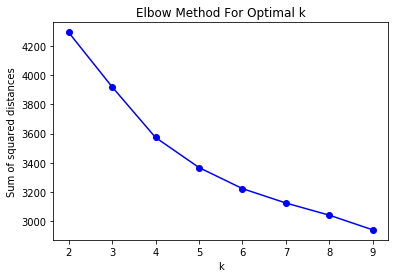

In [88]:
x_kmeans = x30

sum_of_squared_distances = []
K = range(2,10)
for k in K:
    kmeans = KMeans(n_clusters=k, init='k-means++')
    kmeans = kmeans.fit(x_kmeans)
    sum_of_squared_distances.append(kmeans.inertia_)  #Sum of squared distances of samples to their closest cluster center
    
plt.plot(K, sum_of_squared_distances, 'bo-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

# SelectKBest chi2 k = 80/50/30 cut=4

In [89]:
x = dummy1.iloc[:, 5:]
y = dummy1['Salary_group_cut4']

print("******************SelectKBest=80, cut=4*******************************")
kbest80 = SelectKBest(chi2, k=80)
x80 = kbest80.fit_transform(x, y)
x_train, x_test, y_train, y_test = train_test_split(x80, y, test_size = 0.3, random_state=0)

lr = LogisticRegression(multi_class = 'auto', solver = 'newton-cg', random_state=0)
lr.fit(x_train, y_train)
print('\nLogisticRegression score: ', lr.score(x_test, y_test))
print('LogisticRegression train_set score: ', lr.score(x_train, y_train))
print('LogisticRegression f1: ', f1_score(y_test, lr.predict(x_test), average='weighted'))

svm = SVC(kernel = 'linear', random_state=0)
svm.fit(x_train, y_train)
print('\nSVM Linear score: ', svm.score(x_test, y_test))
print('SVM Linear train_set score: ', svm.score(x_train, y_train))
print('SVM Linear f1: ', f1_score(y_test, svm.predict(x_test), average='weighted'))

rbf = SVC(kernel='rbf', random_state=0)
rbf.fit(x_train, y_train)
print('\nSVM RBF score: ', rbf.score(x_test, y_test))
print('SVM RBF train_set score: ', rbf.score(x_train, y_train))
print('SVM RBF f1: ', f1_score(y_test, rbf.predict(x_test), average='weighted'))

tree = DecisionTreeClassifier(random_state=0)
tree.fit(x_train, y_train)
print('\nDC score: ', tree.score(x_test, y_test))
print('DC train_set score: ', tree.score(x_train, y_train))
print('DC f1: ', f1_score(y_test, tree.predict(x_test), average='weighted'))

rf = RandomForestClassifier(n_estimators = 100, random_state=0)
rf.fit(x_train, y_train)
print('\nRF score: ', rf.score(x_test, y_test))
print('RF train_set score: ', rf.score(x_train, y_train))
print('RF f1: ', f1_score(y_test, rf.predict(x_test), average='weighted'))


print("\n\n***************SelectKBest=50, cut=4**********************")
kbest50 = SelectKBest(chi2, k=50)
x50 = kbest50.fit_transform(x, y)
x_train, x_test, y_train, y_test = train_test_split(x50, y, test_size = 0.3, random_state=0)

lr = LogisticRegression(multi_class = 'auto', solver = 'newton-cg', random_state=0)
lr.fit(x_train, y_train)
print('\nLogisticRegression score: ', lr.score(x_test, y_test))
print('LogisticRegression train_set score: ', lr.score(x_train, y_train))
print('LogisticRegression f1: ', f1_score(y_test, lr.predict(x_test), average='weighted'))

svm = SVC(kernel = 'linear', random_state=0)
svm.fit(x_train, y_train)
print('\nSVM Linear score: ', svm.score(x_test, y_test))
print('SVM Linear train_set score: ', svm.score(x_train, y_train))
print('SVM Linear f1: ', f1_score(y_test, svm.predict(x_test), average='weighted'))

rbf = SVC(kernel='rbf', random_state=0)
rbf.fit(x_train, y_train)
print('\nSVM RBF score: ', rbf.score(x_test, y_test))
print('SVM RBF train_set score: ', rbf.score(x_train, y_train))
print('SVM RBF f1: ', f1_score(y_test, rbf.predict(x_test), average='weighted'))

tree = DecisionTreeClassifier(random_state=0)
tree.fit(x_train, y_train)
print('\nDC score: ', tree.score(x_test, y_test))
print('DC train_set score: ', tree.score(x_train, y_train))
print('DC f1: ', f1_score(y_test, tree.predict(x_test), average='weighted'))

rf = RandomForestClassifier(n_estimators = 100, random_state=0)
rf.fit(x_train, y_train)
print('\nRF score: ', rf.score(x_test, y_test))
print('RF train_set score: ', rf.score(x_train, y_train))
print('RF f1: ', f1_score(y_test, rf.predict(x_test), average='weighted'))


print("\n\n***************SelectKBest=30, cut=4**********************")
kbest30 = SelectKBest(chi2, k=30)
x30 = kbest30.fit_transform(x, y)
x_train, x_test, y_train, y_test = train_test_split(x30, y, test_size = 0.3, random_state=0)

lr = LogisticRegression(multi_class = 'auto', solver = 'newton-cg', random_state=0)
lr.fit(x_train, y_train)
print('\nLogisticRegression score: ', lr.score(x_test, y_test))
print('LogisticRegression train_set score: ', lr.score(x_train, y_train))
print('LogisticRegression f1: ', f1_score(y_test, lr.predict(x_test), average='weighted'))

svm = SVC(kernel = 'linear', random_state=0)
svm.fit(x_train, y_train)
print('\nSVM Linear score: ', svm.score(x_test, y_test))
print('SVM Linear train_set score: ', svm.score(x_train, y_train))
print('SVM Linear f1: ', f1_score(y_test, svm.predict(x_test), average='weighted'))

rbf = SVC(kernel='rbf', random_state=0)
rbf.fit(x_train, y_train)
print('\nSVM RBF score: ', rbf.score(x_test, y_test))
print('SVM RBF train_set score: ', rbf.score(x_train, y_train))
print('SVM RBF f1: ', f1_score(y_test, rbf.predict(x_test), average='weighted'))

tree = DecisionTreeClassifier(random_state=0)
tree.fit(x_train, y_train)
print('\nDC score: ', tree.score(x_test, y_test))
print('DC train_set score: ', tree.score(x_train, y_train))
print('DC f1: ', f1_score(y_test, tree.predict(x_test), average='weighted'))

rf = RandomForestClassifier(n_estimators = 100, random_state=0)
rf.fit(x_train, y_train)
print('\nRF score: ', rf.score(x_test, y_test))
print('RF train_set score: ', rf.score(x_train, y_train))
print('RF f1: ', f1_score(y_test, rf.predict(x_test), average='weighted'))

******************SelectKBest=80, cut=4*******************************

LogisticRegression score:  0.6806387225548902
LogisticRegression train_set score:  0.7080479452054794
LogisticRegression f1:  0.6565264128283594


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)



SVM Linear score:  0.6846307385229541
SVM Linear train_set score:  0.7080479452054794
SVM Linear f1:  0.6524735048982329


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



SVM RBF score:  0.656686626746507
SVM RBF train_set score:  0.6523972602739726
SVM RBF f1:  0.5466796694755524

DC score:  0.5608782435129741
DC train_set score:  0.990582191780822
DC f1:  0.5693401972538316


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)



RF score:  0.6826347305389222
RF train_set score:  0.990582191780822
RF f1:  0.6453444961927997


***************SelectKBest=50, cut=4**********************

LogisticRegression score:  0.6906187624750499
LogisticRegression train_set score:  0.7037671232876712
LogisticRegression f1:  0.6678484322248519


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



SVM Linear score:  0.6746506986027944
SVM Linear train_set score:  0.690068493150685
SVM Linear f1:  0.6338576175309558

SVM RBF score:  0.6766467065868264
SVM RBF train_set score:  0.678082191780822
SVM RBF f1:  0.6030252085150214

DC score:  0.5848303393213573
DC train_set score:  0.9623287671232876
DC f1:  0.5923896611969436


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)



RF score:  0.6726546906187625
RF train_set score:  0.9623287671232876
RF f1:  0.6452780643130789


***************SelectKBest=30, cut=4**********************

LogisticRegression score:  0.6706586826347305
LogisticRegression train_set score:  0.6934931506849316
LogisticRegression f1:  0.6407384635354003

SVM Linear score:  0.6766467065868264


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVM Linear train_set score:  0.6763698630136986
SVM Linear f1:  0.6377570585156803

SVM RBF score:  0.6826347305389222
SVM RBF train_set score:  0.684931506849315
SVM RBF f1:  0.6376956511915421

DC score:  0.5768463073852296
DC train_set score:  0.8741438356164384
DC f1:  0.5776716470743397


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)



RF score:  0.6367265469061876
RF train_set score:  0.8741438356164384
RF f1:  0.6183451189305833


# SelectKBest chi2 k = 80/50/30 qcut=3

In [90]:
x = dummy1.iloc[:, 5:]
y = dummy1['Salary_group_qcut3']

print("******************SelectKBest=80, qcut=3*******************************")
kbest80 = SelectKBest(chi2, k=80)
x80 = kbest80.fit_transform(x, y)
x_train, x_test, y_train, y_test = train_test_split(x80, y, test_size = 0.3, random_state=0)

lr = LogisticRegression(multi_class = 'auto', solver = 'newton-cg', random_state=0)
lr.fit(x_train, y_train)
print('\nLogisticRegression score: ', lr.score(x_test, y_test))
print('LogisticRegression train_set score: ', lr.score(x_train, y_train))
print('LogisticRegression f1: ', f1_score(y_test, lr.predict(x_test), average='weighted'))

svm = SVC(kernel = 'linear', random_state=0)
svm.fit(x_train, y_train)
print('\nSVM Linear score: ', svm.score(x_test, y_test))
print('SVM Linear train_set score: ', svm.score(x_train, y_train))
print('SVM Linear f1: ', f1_score(y_test, svm.predict(x_test), average='weighted'))

rbf = SVC(kernel='rbf', random_state=0)
rbf.fit(x_train, y_train)
print('\nSVM RBF score: ', rbf.score(x_test, y_test))
print('SVM RBF train_set score: ', rbf.score(x_train, y_train))
print('SVM RBF f1: ', f1_score(y_test, rbf.predict(x_test), average='weighted'))

tree = DecisionTreeClassifier(random_state=0)
tree.fit(x_train, y_train)
print('\nDC score: ', tree.score(x_test, y_test))
print('DC train_set score: ', tree.score(x_train, y_train))
print('DC f1: ', f1_score(y_test, tree.predict(x_test), average='weighted'))

rf = RandomForestClassifier(n_estimators = 100, random_state=0)
rf.fit(x_train, y_train)
print('\nRF score: ', rf.score(x_test, y_test))
print('RF train_set score: ', rf.score(x_train, y_train))
print('RF f1: ', f1_score(y_test, rf.predict(x_test), average='weighted'))


print("\n\n***************SelectKBest=50, qcut=3**********************")
kbest50 = SelectKBest(chi2, k=50)
x50 = kbest50.fit_transform(x, y)
x_train, x_test, y_train, y_test = train_test_split(x50, y, test_size = 0.3, random_state=0)

lr = LogisticRegression(multi_class = 'auto', solver = 'newton-cg', random_state=0)
lr.fit(x_train, y_train)
print('\nLogisticRegression score: ', lr.score(x_test, y_test))
print('LogisticRegression train_set score: ', lr.score(x_train, y_train))
print('LogisticRegression f1: ', f1_score(y_test, lr.predict(x_test), average='weighted'))

svm = SVC(kernel = 'linear', random_state=0)
svm.fit(x_train, y_train)
print('\nSVM Linear score: ', svm.score(x_test, y_test))
print('SVM Linear train_set score: ', svm.score(x_train, y_train))
print('SVM Linear f1: ', f1_score(y_test, svm.predict(x_test), average='weighted'))

rbf = SVC(kernel='rbf', random_state=0)
rbf.fit(x_train, y_train)
print('\nSVM RBF score: ', rbf.score(x_test, y_test))
print('SVM RBF train_set score: ', rbf.score(x_train, y_train))
print('SVM RBF f1: ', f1_score(y_test, rbf.predict(x_test), average='weighted'))

tree = DecisionTreeClassifier(random_state=0)
tree.fit(x_train, y_train)
print('\nDC score: ', tree.score(x_test, y_test))
print('DC train_set score: ', tree.score(x_train, y_train))
print('DC f1: ', f1_score(y_test, tree.predict(x_test), average='weighted'))

rf = RandomForestClassifier(n_estimators = 100, random_state=0)
rf.fit(x_train, y_train)
print('\nRF score: ', rf.score(x_test, y_test))
print('RF train_set score: ', rf.score(x_train, y_train))
print('RF f1: ', f1_score(y_test, rf.predict(x_test), average='weighted'))


print("\n\n***************SelectKBest=30, qcut=3**********************")
kbest30 = SelectKBest(chi2, k=30)
x30 = kbest30.fit_transform(x, y)
x_train, x_test, y_train, y_test = train_test_split(x30, y, test_size = 0.3, random_state=0)

lr = LogisticRegression(multi_class = 'auto', solver = 'newton-cg', random_state=0)
lr.fit(x_train, y_train)
print('\nLogisticRegression score: ', lr.score(x_test, y_test))
print('LogisticRegression train_set score: ', lr.score(x_train, y_train))
print('LogisticRegression f1: ', f1_score(y_test, lr.predict(x_test), average='weighted'))

svm = SVC(kernel = 'linear', random_state=0)
svm.fit(x_train, y_train)
print('\nSVM Linear score: ', svm.score(x_test, y_test))
print('SVM Linear train_set score: ', svm.score(x_train, y_train))
print('SVM Linear f1: ', f1_score(y_test, svm.predict(x_test), average='weighted'))

rbf = SVC(kernel='rbf', random_state=0)
rbf.fit(x_train, y_train)
print('\nSVM RBF score: ', rbf.score(x_test, y_test))
print('SVM RBF train_set score: ', rbf.score(x_train, y_train))
print('SVM RBF f1: ', f1_score(y_test, rbf.predict(x_test), average='weighted'))

tree = DecisionTreeClassifier(random_state=0)
tree.fit(x_train, y_train)
print('\nDC score: ', tree.score(x_test, y_test))
print('DC train_set score: ', tree.score(x_train, y_train))
print('DC f1: ', f1_score(y_test, tree.predict(x_test), average='weighted'))

rf = RandomForestClassifier(n_estimators = 100, random_state=0)
rf.fit(x_train, y_train)
print('\nRF score: ', rf.score(x_test, y_test))
print('RF train_set score: ', rf.score(x_train, y_train))
print('RF f1: ', f1_score(y_test, rf.predict(x_test), average='weighted'))

******************SelectKBest=80, qcut=3*******************************

LogisticRegression score:  0.592814371257485
LogisticRegression train_set score:  0.6335616438356164
LogisticRegression f1:  0.5855343327059124

SVM Linear score:  0.5848303393213573
SVM Linear train_set score:  0.6446917808219178
SVM Linear f1:  0.5798599632878594


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



SVM RBF score:  0.6007984031936128
SVM RBF train_set score:  0.5967465753424658
SVM RBF f1:  0.599216409826654

DC score:  0.5389221556886228
DC train_set score:  0.990582191780822
DC f1:  0.5354811248566581

RF score:  0.6127744510978044
RF train_set score:  0.990582191780822
RF f1:  0.6057151642854933


***************SelectKBest=50, qcut=3**********************

LogisticRegression score:  0.6027944111776448
LogisticRegression train_set score:  0.6018835616438356
LogisticRegression f1:  0.5905621820151253

SVM Linear score:  0.6127744510978044
SVM Linear train_set score:  0.6190068493150684
SVM Linear f1:  0.6083087051672093


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



SVM RBF score:  0.590818363273453
SVM RBF train_set score:  0.5898972602739726
SVM RBF f1:  0.5946264339133676

DC score:  0.5608782435129741
DC train_set score:  0.949486301369863
DC f1:  0.5559884722184867

RF score:  0.5948103792415169
RF train_set score:  0.949486301369863
RF f1:  0.5850141840089161


***************SelectKBest=30, qcut=3**********************

LogisticRegression score:  0.5868263473053892
LogisticRegression train_set score:  0.5702054794520548
LogisticRegression f1:  0.5769986628837687

SVM Linear score:  0.590818363273453
SVM Linear train_set score:  0.5684931506849316
SVM Linear f1:  0.5960732515532867

SVM RBF score:  0.5828343313373253
SVM RBF train_set score:  0.565068493150685
SVM RBF f1:  0.5872783741710818


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



DC score:  0.5369261477045908
DC train_set score:  0.8578767123287672
DC f1:  0.5273861509222646

RF score:  0.562874251497006
RF train_set score:  0.8578767123287672
RF f1:  0.5550480754721954


# SelectKBest chi2 k = 80/50/30 qcut=4

In [92]:
x = dummy1.iloc[:, 5:]
y = dummy1['Salary_group_qcut3']

print("******************SelectKBest=80, qcut=3*******************************")
kbest80 = SelectKBest(chi2, k=80)
x80 = kbest80.fit_transform(x, y)
x_train, x_test, y_train, y_test = train_test_split(x80, y, test_size = 0.3, random_state=0)

lr = LogisticRegression(multi_class = 'auto', solver = 'newton-cg', random_state=0)
lr.fit(x_train, y_train)
print('\nLogisticRegression score: ', lr.score(x_test, y_test))
print('LogisticRegression train_set score: ', lr.score(x_train, y_train))
print('LogisticRegression f1: ', f1_score(y_test, lr.predict(x_test), average='weighted'))

svm = SVC(kernel = 'linear', random_state=0)
svm.fit(x_train, y_train)
print('\nSVM Linear score: ', svm.score(x_test, y_test))
print('SVM Linear train_set score: ', svm.score(x_train, y_train))
print('SVM Linear f1: ', f1_score(y_test, svm.predict(x_test), average='weighted'))

rbf = SVC(kernel='rbf', random_state=0)
rbf.fit(x_train, y_train)
print('\nSVM RBF score: ', rbf.score(x_test, y_test))
print('SVM RBF train_set score: ', rbf.score(x_train, y_train))
print('SVM RBF f1: ', f1_score(y_test, rbf.predict(x_test), average='weighted'))

tree = DecisionTreeClassifier(random_state=0)
tree.fit(x_train, y_train)
print('\nDC score: ', tree.score(x_test, y_test))
print('DC train_set score: ', tree.score(x_train, y_train))
print('DC f1: ', f1_score(y_test, tree.predict(x_test), average='weighted'))

rf = RandomForestClassifier(n_estimators = 100, random_state=0)
rf.fit(x_train, y_train)
print('\nRF score: ', rf.score(x_test, y_test))
print('RF train_set score: ', rf.score(x_train, y_train))
print('RF f1: ', f1_score(y_test, rf.predict(x_test), average='weighted'))


print("\n\n***************SelectKBest=50, qcut=3**********************")
kbest50 = SelectKBest(chi2, k=50)
x50 = kbest50.fit_transform(x, y)
x_train, x_test, y_train, y_test = train_test_split(x50, y, test_size = 0.3, random_state=0)

lr = LogisticRegression(multi_class = 'auto', solver = 'newton-cg', random_state=0)
lr.fit(x_train, y_train)
print('\nLogisticRegression score: ', lr.score(x_test, y_test))
print('LogisticRegression train_set score: ', lr.score(x_train, y_train))
print('LogisticRegression f1: ', f1_score(y_test, lr.predict(x_test), average='weighted'))

svm = SVC(kernel = 'linear', random_state=0)
svm.fit(x_train, y_train)
print('\nSVM Linear score: ', svm.score(x_test, y_test))
print('SVM Linear train_set score: ', svm.score(x_train, y_train))
print('SVM Linear f1: ', f1_score(y_test, svm.predict(x_test), average='weighted'))

rbf = SVC(kernel='rbf', random_state=0)
rbf.fit(x_train, y_train)
print('\nSVM RBF score: ', rbf.score(x_test, y_test))
print('SVM RBF train_set score: ', rbf.score(x_train, y_train))
print('SVM RBF f1: ', f1_score(y_test, rbf.predict(x_test), average='weighted'))

tree = DecisionTreeClassifier(random_state=0)
tree.fit(x_train, y_train)
print('\nDC score: ', tree.score(x_test, y_test))
print('DC train_set score: ', tree.score(x_train, y_train))
print('DC f1: ', f1_score(y_test, tree.predict(x_test), average='weighted'))

rf = RandomForestClassifier(n_estimators = 100, random_state=0)
rf.fit(x_train, y_train)
print('\nRF score: ', rf.score(x_test, y_test))
print('RF train_set score: ', rf.score(x_train, y_train))
print('RF f1: ', f1_score(y_test, rf.predict(x_test), average='weighted'))


print("\n\n***************SelectKBest=30, qcut=3**********************")
kbest30 = SelectKBest(chi2, k=30)
x30 = kbest30.fit_transform(x, y)
x_train, x_test, y_train, y_test = train_test_split(x30, y, test_size = 0.3, random_state=0)

lr = LogisticRegression(multi_class = 'auto', solver = 'newton-cg', random_state=0)
lr.fit(x_train, y_train)
print('\nLogisticRegression score: ', lr.score(x_test, y_test))
print('LogisticRegression train_set score: ', lr.score(x_train, y_train))
print('LogisticRegression f1: ', f1_score(y_test, lr.predict(x_test), average='weighted'))

svm = SVC(kernel = 'linear', random_state=0)
svm.fit(x_train, y_train)
print('\nSVM Linear score: ', svm.score(x_test, y_test))
print('SVM Linear train_set score: ', svm.score(x_train, y_train))
print('SVM Linear f1: ', f1_score(y_test, svm.predict(x_test), average='weighted'))

rbf = SVC(kernel='rbf', random_state=0)
rbf.fit(x_train, y_train)
print('\nSVM RBF score: ', rbf.score(x_test, y_test))
print('SVM RBF train_set score: ', rbf.score(x_train, y_train))
print('SVM RBF f1: ', f1_score(y_test, rbf.predict(x_test), average='weighted'))

tree = DecisionTreeClassifier(random_state=0)
tree.fit(x_train, y_train)
print('\nDC score: ', tree.score(x_test, y_test))
print('DC train_set score: ', tree.score(x_train, y_train))
print('DC f1: ', f1_score(y_test, tree.predict(x_test), average='weighted'))

rf = RandomForestClassifier(n_estimators = 100, random_state=0)
rf.fit(x_train, y_train)
print('\nRF score: ', rf.score(x_test, y_test))
print('RF train_set score: ', rf.score(x_train, y_train))
print('RF f1: ', f1_score(y_test, rf.predict(x_test), average='weighted'))

******************SelectKBest=80, qcut=3*******************************

LogisticRegression score:  0.592814371257485
LogisticRegression train_set score:  0.6335616438356164
LogisticRegression f1:  0.5855343327059124

SVM Linear score:  0.5848303393213573
SVM Linear train_set score:  0.6446917808219178
SVM Linear f1:  0.5798599632878594


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



SVM RBF score:  0.6007984031936128
SVM RBF train_set score:  0.5967465753424658
SVM RBF f1:  0.599216409826654

DC score:  0.5389221556886228
DC train_set score:  0.990582191780822
DC f1:  0.5354811248566581

RF score:  0.6127744510978044
RF train_set score:  0.990582191780822
RF f1:  0.6057151642854933


***************SelectKBest=50, qcut=3**********************

LogisticRegression score:  0.6027944111776448
LogisticRegression train_set score:  0.6018835616438356
LogisticRegression f1:  0.5905621820151253

SVM Linear score:  0.6127744510978044
SVM Linear train_set score:  0.6190068493150684
SVM Linear f1:  0.6083087051672093


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



SVM RBF score:  0.590818363273453
SVM RBF train_set score:  0.5898972602739726
SVM RBF f1:  0.5946264339133676

DC score:  0.5608782435129741
DC train_set score:  0.949486301369863
DC f1:  0.5559884722184867

RF score:  0.5948103792415169
RF train_set score:  0.949486301369863
RF f1:  0.5850141840089161


***************SelectKBest=30, qcut=3**********************

LogisticRegression score:  0.5868263473053892
LogisticRegression train_set score:  0.5702054794520548
LogisticRegression f1:  0.5769986628837687

SVM Linear score:  0.590818363273453
SVM Linear train_set score:  0.5684931506849316
SVM Linear f1:  0.5960732515532867


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



SVM RBF score:  0.5828343313373253
SVM RBF train_set score:  0.565068493150685
SVM RBF f1:  0.5872783741710818

DC score:  0.5369261477045908
DC train_set score:  0.8578767123287672
DC f1:  0.5273861509222646

RF score:  0.562874251497006
RF train_set score:  0.8578767123287672
RF f1:  0.5550480754721954


In [271]:
###Score Table which list all the scores 
score = pd.read_excel("/Users/yinghua/Documents/MachineLearningProjectScoreTable.xlsx")

In [272]:
score

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14
0,NaN,Score Table,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,cut = 3,NaN,NaN,cut = 4,NaN,NaN,qcut = 3,NaN,NaN,qcut4,NaN,NaN
2,NaN,NaN,NaN,Test Score,Train Score,F1 Score,Test Score,Train Score,F1 Score,Test Score,Train Score,F1 Score,Test Score,Train Score,F1 Score
3,NaN,LR,All Features,0.7544910179640718,0.761986301369863,0.7487426525527948,0.6706586826347305,0.7029109589041096,0.6364910259862956,0.5748502994011976,0.6378424657534246,0.5658827374813086,0.500998003992016,0.5676369863013698,0.48639562992711394
4,NaN,NaN,PCA,0.7524950099800399,0.7414383561643836,0.7469172848760406,0.654690618762475,0.6832191780821918,0.6238284474417072,0.5768463073852296,0.615582191780822,0.5636234441228517,0.46706586826347307,0.5402397260273972,0.44859524251537436
5,NaN,NaN,RFE(80),0.7684630738522954,0.7636986301369864,0.7642912461360433,0.6646706586826348,0.7200342465753424,0.6476098894359276,0.5748502994011976,0.6412671232876712,0.5675726702236473,0.5748502994011976,0.6412671232876712,0.5675726702236473
6,NaN,NaN,RFE(50),0.7405189620758483,0.7517123287671232,0.7367471846430597,0.6586826347305389,0.7046232876712328,0.6339971169798014,0.5868263473053892,0.6284246575342466,0.5785238151220966,0.5868263473053892,0.6284246575342466,0.5785238151220966
7,NaN,NaN,RFE(30),0.7445109780439122,0.7422945205479452,0.7411869165414077,0.6746506986027944,0.7037671232876712,0.6462814716288492,0.5708582834331337,0.5804794520547946,0.5745111603401701,0.5708582834331337,0.5804794520547946,0.5745111603401701
8,NaN,NaN,KBest(80),0.7524950099800399,0.7542808219178082,0.7472707732577953,0.6806387225548902,0.7080479452054794,0.6565264128283594,0.592814371257485,0.6335616438356164,0.5855343327059124,0.592814371257485,0.6335616438356164,0.5855343327059124
9,NaN,NaN,KBest(50),0.7624750499001997,0.7440068493150684,0.758451828599545,0.6906187624750499,0.7037671232876712,0.6678484322248519,0.6027944111776448,0.6018835616438356,0.5905621820151253,0.6027944111776448,0.6018835616438356,0.5905621820151253


# Test - Tuning parameters for qcut=3 RandomForest 

In [340]:
##RFE80
x = dummy1.iloc[:, 5:]
y = dummy1['Salary_group_qcut3']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state=0)

estimator = RandomForestClassifier(n_estimators = 100, random_state=0)
selector1 = RFE(estimator, 80, step=1)
selector1 = selector1.fit(x_train, y_train) 
print('\nRF score: ', selector1.score(x_test, y_test))
print('RF train_set score: ', selector1.score(x_train, y_train))
print('RF f1: ', f1_score(y_test, selector1.predict(x_test), average='weighted'))
print(classification_report(y_test, selector1.predict(x_test)))
col_rf_80 = dummy1.iloc[:, 5:].columns[selector1.get_support()]
print(col_rf_80)


RF score:  0.6387225548902196
RF train_set score:  0.9957191780821918
RF f1:  0.6335353011888741
              precision    recall  f1-score   support

           1       0.72      0.79      0.75       222
           2       0.54      0.48      0.51       161
           3       0.59      0.56      0.57       118

   micro avg       0.64      0.64      0.64       501
   macro avg       0.62      0.61      0.61       501
weighted avg       0.63      0.64      0.63       501

Index(['Job_class', 'Experience', 'Contract_cdi', 'Location_33', 'Location_44',
       'Location_69', 'Location_75', 'data', 'statistique', 'analyse', 'ml',
       'dl', 'algorithmes', 'bases de données', 'excel', 'BI', 'IA', 'python',
       'visualisation', 'ann', 'gan', 'sql', 'mysql', 'mongo', 'nosql', 'sas',
       'spark', 'big data', 'scala', 'tableau', 'fullstack', 'frontend',
       'backend', 'design', 'mobile', 'test', 'maintenance', 'déploiement',
       'cloud', 'js', 'html', 'css', 'java', 'c#', 'c++',

In [344]:
##Compare RFE 80 with RandomForest feature importances 80

x = dummy1.iloc[:, 5:]
y = dummy1['Salary_group_qcut3']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state=0)

rfc = RandomForestClassifier(random_state=0)
rfc.fit(x_train, y_train)

importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1] # Sort feature importances in descending order
names = [x_train.columns[i] for i in indices]

f80 = pd.concat([dummy1[names[0:81]], dummy1['Salary_group_qcut3']], axis = 1)

x = f80.iloc[:, :-1]
y = f80['Salary_group_qcut3']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state=0)

rfc80 = RandomForestClassifier(random_state=0)
rfc80.fit(x_train, y_train)
print(rfc80.score(x_test, y_test))
print(rfc80.score(x_train,y_train))
print(f1_score(y_test, rfc80.predict(x_test), average='weighted'))
print(classification_report(y_test, rfc80.predict(x_test)))

0.5708582834331337
0.9845890410958904
0.5652901073131835
              precision    recall  f1-score   support

           1       0.67      0.73      0.70       222
           2       0.46      0.40      0.43       161
           3       0.50      0.49      0.50       118

   micro avg       0.57      0.57      0.57       501
   macro avg       0.54      0.54      0.54       501
weighted avg       0.56      0.57      0.57       501



/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [346]:
##rfe 80
##80 columns of features 
df_rfe80 = dummy1[['Job_class', 'Experience', 'Contract_cdi', 'Location_33', 'Location_44',
       'Location_69', 'Location_75', 'data', 'statistique', 'analyse', 'ml',
       'dl', 'algorithmes', 'bases de données', 'excel', 'BI', 'IA', 'python',
       'visualisation', 'ann', 'gan', 'sql', 'mysql', 'mongo', 'nosql', 'sas',
       'spark', 'big data', 'scala', 'tableau', 'fullstack', 'frontend',
       'backend', 'design', 'mobile', 'test', 'maintenance', 'déploiement',
       'cloud', 'js', 'html', 'css', 'java', 'c#', 'c++', 'swift', 'ruby',
       'php', 'docker', '.net', 'aws', 'azure', 'api', 'angularjs',
       'bootstrap', 'django', 'jquery', 'frameworks', 'poo', 'git', 'linux',
       'symfony', 'jenkins', 'saas', 'mvc', 'android', 'kubernetes',
       'postgresql', 'elasticsearch', 'erp', 'finance', 'assurance',
       'transport', 'santé', 'luxe', 'bancaire', 'anglais', 'agile',
       'international', 'startup']]

In [348]:
##Add y column
df_rfe80 = pd.concat([df_rfe80, dummy1['Salary_group_qcut3']], axis = 1)

In [357]:
###Take the first 80 columns according to RFE
x = df_rfe80.iloc[:, :-1]
y = df_rfe80['Salary_group_qcut3']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state=0)

rfc = RandomForestClassifier(n_estimators = 100, random_state=0)
rfc.fit(x_train, y_train)

print(rfc.score(x_test, y_test))
print(rfc.score(x_train,y_train))
print(f1_score(y_test, rfc.predict(x_test), average='weighted'))
print(classification_report(y_test, rfc.predict(x_test)))

0.6387225548902196
0.9957191780821918
0.6335353011888741
              precision    recall  f1-score   support

           1       0.72      0.79      0.75       222
           2       0.54      0.48      0.51       161
           3       0.59      0.56      0.57       118

   micro avg       0.64      0.64      0.64       501
   macro avg       0.62      0.61      0.61       501
weighted avg       0.63      0.64      0.63       501



# Tuning n_estimators 

0.5755381218560647 131


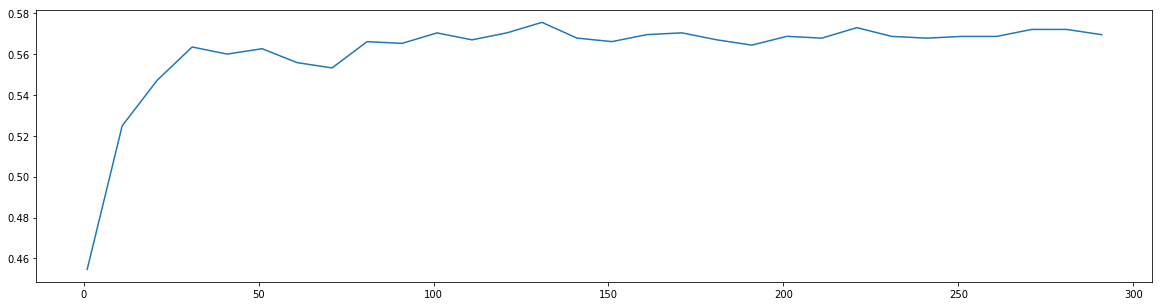

In [358]:
import matplotlib.pyplot as plt
scorel = []

for i in range(0, 300, 10):
    rfc = RandomForestClassifier(n_estimators=i+1, random_state=0)
    score = cross_val_score(rfc, x_train, y_train, cv=10).mean()
    scorel.append(score)

print(max(scorel), (scorel.index(max(scorel))*10+1))

plt.figure(figsize=[20, 5])
plt.plot(range(1, 301, 10), scorel)
plt.show()

0.5764148021599804 127


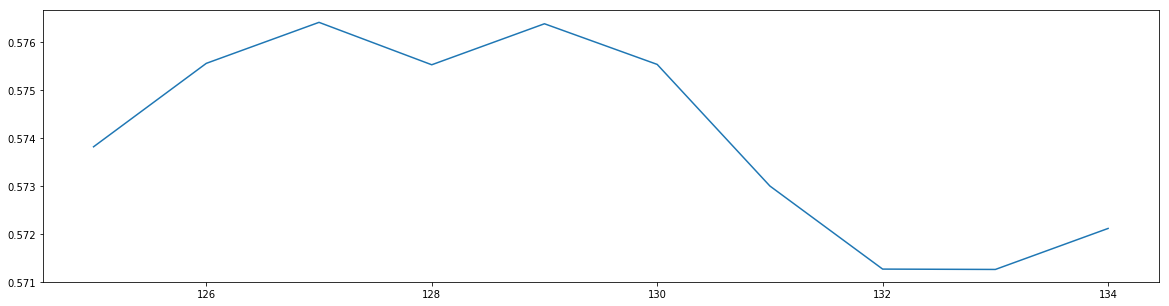

In [359]:
scorel = []

for i in range(125, 135):
    rfc = RandomForestClassifier(n_estimators=i+1, random_state=0)
    score = cross_val_score(rfc, x_train, y_train, cv=10).mean()
    scorel.append(score)

print(max(scorel), ([*range(125, 135)][scorel.index(max(scorel))]))

plt.figure(figsize=[20, 5])
plt.plot(range(125, 135), scorel)
plt.show()

# Tuning criterion

In [366]:
c = RandomForestClassifier(n_estimators=127, criterion = 'gini', random_state=20)
c.fit(x_train, y_train)
print(c.score(x_test, y_test))
print(c.score(x_train,y_train))
print(f1_score(y_test, c.predict(x_test), average='weighted'))
print(classification_report(y_test, c.predict(x_test)))
      
c = RandomForestClassifier(n_estimators=127, criterion = 'entropy', random_state=20)
c.fit(x_train, y_train)
print(c.score(x_test, y_test))
print(c.score(x_train,y_train))
print(f1_score(y_test, c.predict(x_test), average='weighted'))
print(classification_report(y_test, c.predict(x_test)))

0.6347305389221557
0.9957191780821918
0.628217507072281
              precision    recall  f1-score   support

           1       0.71      0.80      0.75       222
           2       0.56      0.49      0.52       161
           3       0.56      0.52      0.54       118

   micro avg       0.63      0.63      0.63       501
   macro avg       0.61      0.60      0.60       501
weighted avg       0.63      0.63      0.63       501

0.6207584830339321
0.9957191780821918
0.6137779961625265
              precision    recall  f1-score   support

           1       0.71      0.79      0.75       222
           2       0.51      0.44      0.47       161
           3       0.57      0.54      0.55       118

   micro avg       0.62      0.62      0.62       501
   macro avg       0.59      0.59      0.59       501
weighted avg       0.61      0.62      0.61       501



# Tuning max_depth

0.5891767447436647 12


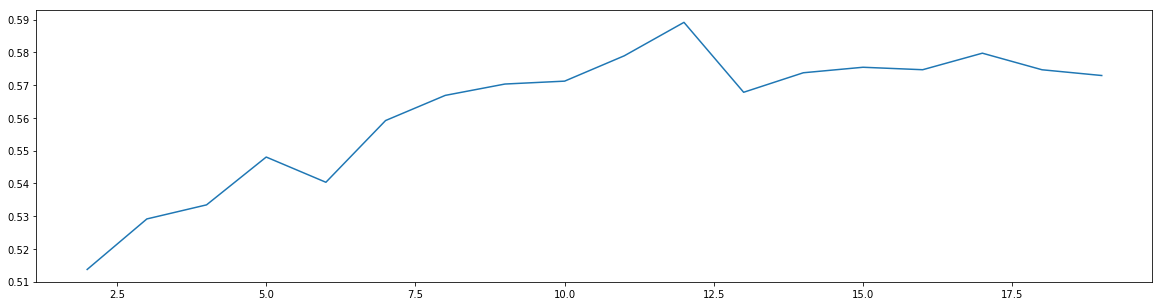

In [367]:
scorel = []

for i in range(2, 20):
    rfc = RandomForestClassifier(n_estimators=127, criterion = 'gini', max_depth = i+1, random_state=0)
    score = cross_val_score(rfc, x_train, y_train, cv=10).mean()
    scorel.append(score)

print(max(scorel), ([*range(2, 20)][scorel.index(max(scorel))]))

plt.figure(figsize=[20, 5])
plt.plot(range(2, 20), scorel)
plt.show()

0.5891767447436647 12


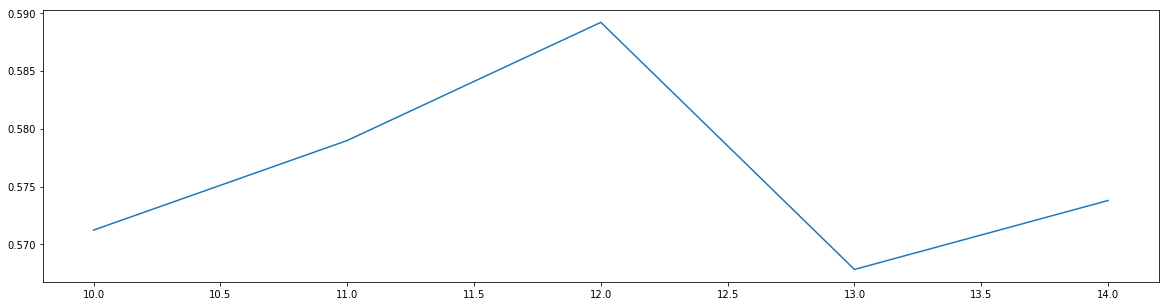

In [370]:
scorel = []

for i in range(10, 15):
    rfc = RandomForestClassifier(n_estimators=127, criterion = 'gini', max_depth = i+1, random_state=0)
    score = cross_val_score(rfc, x_train, y_train, cv=10).mean()
    scorel.append(score)

print(max(scorel), ([*range(10, 15)][scorel.index(max(scorel))]))

plt.figure(figsize=[20, 5])
plt.plot(range(10, 15), scorel)
plt.show()

In [371]:
rfc = RandomForestClassifier(n_estimators=127, criterion = 'gini', max_depth = 12, random_state=0)
rfc.fit(x_train, y_train)
print(rfc.score(x_test, y_test))
print(rfc.score(x_train,y_train))
print(f1_score(y_test, rfc.predict(x_test), average='weighted'))
print(classification_report(y_test, rfc.predict(x_test)))

0.6207584830339321
0.925513698630137
0.6111820262978278
              precision    recall  f1-score   support

           1       0.69      0.81      0.75       222
           2       0.54      0.43      0.48       161
           3       0.54      0.52      0.53       118

   micro avg       0.62      0.62      0.62       501
   macro avg       0.59      0.59      0.59       501
weighted avg       0.61      0.62      0.61       501



# Tuning min_samples_split

0.5814695759464901 4


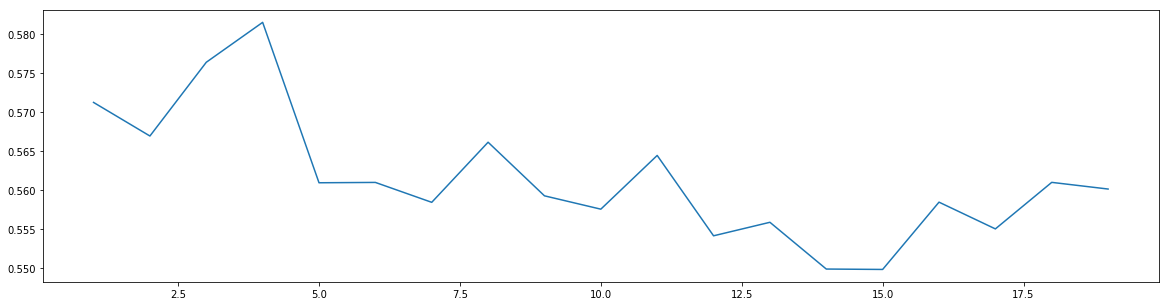

In [374]:
scorel = []

for i in range(1, 20):
    rfc = RandomForestClassifier(n_estimators=127, criterion = 'gini', max_depth = 12, min_samples_split = i+1, \
                                 random_state=0)
    score = cross_val_score(rfc, x_train, y_train, cv=10).mean()
    scorel.append(score)

print(max(scorel), ([*range(1, 20)][scorel.index(max(scorel))]))

plt.figure(figsize=[20, 5])
plt.plot(range(1, 20), scorel)
plt.show()

# Tuning max_features

0.5849328377966602 20


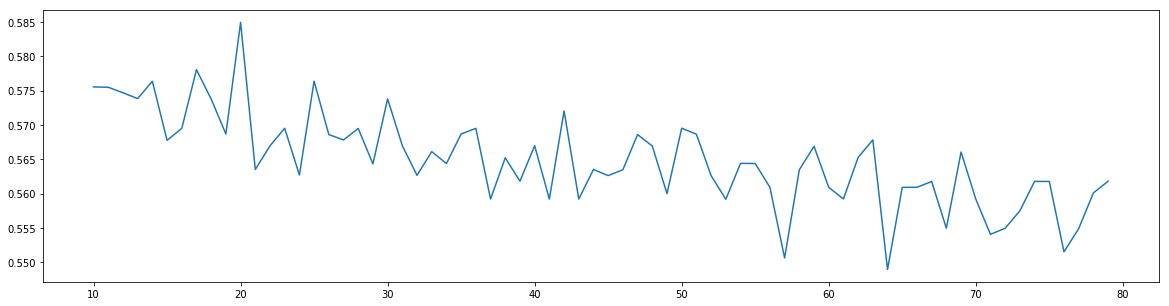

In [389]:
scorel = []

for i in range(10, 80):
    rfc = RandomForestClassifier(n_estimators=121, criterion = 'gini', max_depth = 12, \
                                 max_features = i+1, random_state=0)
    score = cross_val_score(rfc, x_train, y_train, cv=10).mean()
    scorel.append(score)

print(max(scorel), ([*range(10, 80)][scorel.index(max(scorel))]))

plt.figure(figsize=[20, 5])
plt.plot(range(10, 80), scorel)
plt.show()

# Test - GridSearchCV (it takes too long to run the following code. No result.)

In [ ]:
x = df_rfe80.iloc[:, :-1]
y = df_rfe80['Salary_group_qcut3']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state=0)

rfc = RandomForestClassifier(random_state=0)

params = {'n_estimators': np.arange(100, 200, 10), 
          'max_depth': np.arange(2, 20, 2),
          'max_features': np.arange(10, 80, 5), 
          'min_samples_split': np.arange(2, 20, 1),
          'min_samples_leaf': np.arange(2, 10, 1)}

gs = GridSearchCV(rfc, params, cv=10) 
gs.fit(x_train, y_train)

clf = gs.best_estimator_

print('Best params: ', gs.best_params_)
print('Test Score: ', clf.score(x_test, y_test))
print('Train Score: ', clf.score(x_train, y_train))
print('F1 score: ', f1_score(y_test, clf.predict(x_test)))

In [ ]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1] # Sort feature importances in descending order
names = [x_train.columns[i] for i in indices] # Rearrange feature names so they match the sorted feature importances
plt.figure(figsize=(15, 7)) # Create plot
plt.title("Feature Importance") # Create plot title
plt.bar(range(x_train.shape[1]), importances[indices]) # Add bars
plt.xticks(range(x_train.shape[1]), names, rotation=90) # Add feature names as x-axis labels
plt.show() # Show plot

# Tuning SVC Linear (kbest30, cut=3)

In [434]:
x = dummy1.iloc[:, 5:]
y = dummy1['Salary_group_cut3']

kbest30 = SelectKBest(chi2, k=30)
x30 = kbest30.fit_transform(x, y)

x_train, x_test, y_train, y_test = train_test_split(x30, y, test_size = 0.3, random_state=0)

mask = kbest30.get_support()
new_features = dummy1.iloc[:, 5:].columns[mask]

svm = SVC(kernel = 'linear', random_state=0)
score = cross_svm.fit(x_train, y_train)
print('\nSVM Linear score: ', svm.score(x_test, y_test))
print('SVM Linear train_set score: ', svm.score(x_train, y_train))
print('SVM Linear f1: ', f1_score(y_test, svm.predict(x_test), average='weighted'))
print(classification_report(y_test, svm.predict(x_test)))


SVM Linear score:  0.7764471057884231
SVM Linear train_set score:  0.7294520547945206
SVM Linear f1:  0.7644746725711471
              precision    recall  f1-score   support

           1       0.77      0.92      0.84       313
           2       0.79      0.55      0.65       187
           3       0.00      0.00      0.00         1

   micro avg       0.78      0.78      0.78       501
   macro avg       0.52      0.49      0.49       501
weighted avg       0.78      0.78      0.76       501



/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [445]:
svm = SVC(kernel='linear', random_state=10)

params = {'C': [0.01, 0.03, 0.045, 0.05, 0.051, 0.08, 0.1], 'decision_function_shape': ['ovr', 'ovo'], 
         'class_weight' : [None, 'balanced']}
gs = GridSearchCV(svm, params, cv=10) 

gs.fit(x_train, y_train)
print('Best params: ', grid_k_linear.best_params_)

clf = gs.best_estimator_

y_pred = clf.predict(x_test)


print('Test Score: ', clf.score(x_test, y_test))
print('Train Score: ', clf.score(x_train, y_train))
print('f1 score: ', f1_score(y_test, clf.predict(x_test), average='weighted'))

Best params:  {'C': 0.05, 'decision_function_shape': 'ovr'}
Test Score:  0.7544910179640718
Train Score:  0.7226027397260274
f1 score:  0.7392834847729759


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
